<a href="https://colab.research.google.com/github/tnwlvos/machinelearning2/blob/main/TermProject_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Conv1D, TimeDistributed, Dropout,
    Embedding, Reshape, RepeatVector,Lambda, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
def add_macd(df):
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    hist = macd - signal

    df['MACD'] = macd
    df['MACD_signal'] = signal
    df['MACD_hist'] = hist
    return df


def add_return_features(df):
    df = df.copy()
    # === 1) 일간 가격 차이(잔차 계열) ===
    df['d_close1'] = df['Close'].diff(1)     # Close_t - Close_{t-1}

    # 필요하면 Open/High/Low 도 추가 가능
    df['d_open1']  = df['Open'].diff(1)
    df['d_high1']  = df['High'].diff(1)
    df['d_low1']   = df['Low'].diff(1)

    open_v  = df["Open"].values
    high_v  = df["High"].values
    low_v   = df["Low"].values
    close_v = df["Close"].values
    df['vol_chg'] = df['Volume'].pct_change()
    hl_range = high_v - low_v
    oc_body  = close_v - open_v

    body_max = np.maximum(open_v, close_v)
    body_min = np.minimum(open_v, close_v)

    upper_wick = high_v - body_max
    lower_wick = body_min - low_v
    close_pos  = (close_v - low_v) / (hl_range + 1e-6)

    df["HL_range"]   = hl_range
    df["OC_body"]    = oc_body
    df["upper_wick"] = upper_wick
    df["lower_wick"] = lower_wick
    df["close_pos"]  = close_pos



    df = df.dropna()
    return df

def clean_df(df):
    df = df.copy()
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df


def standard_fit(train_df):
    scaler = StandardScaler()
    scaler.fit(train_df)
    return scaler


def standard_transform(scaler, df):
    df_scaled = scaler.transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns, index=df.index)


def Normalization(train_df, test_df):
    scaler = standard_fit(train_df)
    train_scaled = standard_transform(scaler, train_df)
    test_scaled  = standard_transform(scaler, test_df)
    return train_scaled, test_scaled, scaler


In [3]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(
        10000,
        (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads
        )

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=None):
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate,
        })
        return config



In [4]:

def build_transformer_seq2seq_multihead(
          window, input_features, output_features, horizon,
        num_tickers,
        num_layers=3, d_model=128, num_heads=8, dff=256,
        dropout_rate=0.1,
        ticker_dim=16):          # 🔹 종목 임베딩 차원 작게

    enc_inputs = Input(shape=(window, input_features), name="encoder_input")
    dec_inputs = Input(shape=(horizon, output_features), name="decoder_input")
    ticker_id  = Input(shape=(), dtype=tf.int32, name="ticker_id")

    # ---------- Encoder ticker embedding ----------
    ticker_emb = Embedding(num_tickers, ticker_dim)(ticker_id)        # (B, ticker_dim)
    ticker_emb = Lambda(lambda x: tf.expand_dims(x, axis=1))(ticker_emb)  # (B,1,ticker_dim)
    ticker_emb = Lambda(
        lambda x: tf.broadcast_to(x, [tf.shape(x)[0], window, ticker_dim])
    )(ticker_emb)  # (B,window,ticker_dim)

    x_price = Dense(d_model)(enc_inputs)           # (B,window,d_model)
    x = Concatenate(axis=-1)([x_price, ticker_emb])  # (B,window,d_model+ticker_dim)
    x = Dense(d_model)(x)                          # 다시 d_model로 projection

    pos_encoding = positional_encoding(window, d_model)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = EncoderLayer(d_model, num_heads, dff, dropout_rate)(x)

    x = Conv1D(128, 3, padding='causal', activation='relu')(x)
    enc_lstm = LSTM(128, return_state=True, name="encoder_lstm")
    _, state_h, state_c = enc_lstm(x)

    # ---------- Decoder ticker embedding ----------
    dec_ticker_emb = Embedding(num_tickers, ticker_dim)(ticker_id)
    dec_ticker_emb = Lambda(lambda x: tf.expand_dims(x, axis=1))(dec_ticker_emb)
    dec_ticker_emb = Lambda(
        lambda x: tf.broadcast_to(x, [tf.shape(x)[0], horizon, ticker_dim])
    )(dec_ticker_emb)  # (B,horizon,ticker_dim)

    dec_price = Dense(d_model)(dec_inputs)
    dec_x = Concatenate(axis=-1)([dec_price, dec_ticker_emb])
    dec_x = Dense(d_model)(dec_x)

    dec_lstm = LSTM(128, return_sequences=True, name="decoder_lstm")
    dec_x = dec_lstm(dec_x, initial_state=[state_h, state_c])

    shared = TimeDistributed(Dense(64, activation='relu'), name="shared_dense")(dec_x)
    shared = TimeDistributed(Dropout(0.1))(shared)

    resid_out = TimeDistributed(Dense(output_features), name="resid_out")(shared)
    abs_out   = TimeDistributed(Dense(output_features), name="abs_out")(shared)

    model = Model(
        inputs=[enc_inputs, dec_inputs, ticker_id],
        outputs=[resid_out, abs_out],
        name="transformer_seq2seq_with_ticker"
    )

    return model

In [5]:
def make_seq2seq_train_resid(df_scaled, window, horizon):
    """
    df_scaled: 정규화된 DataFrame (OHLCV + 지표)
    window   : encoder가 보는 과거 길이
    horizon  : 예측 날 수 (예: 4)
    return:
        X_enc   : (N, window, F)
        dec_in  : (N, horizon, 4)  # teacher forcing용 decoder 입력
        y_resid : (N, horizon, 4)  # Δ(미래 OHLC - 마지막 OHLC)
        last_ohlc_in_window : (N, 4)
    """
    df_scaled = df_scaled.copy()
    raw_all  = df_scaled.values.astype(np.float32)                       # (N,F)
    raw_ohlc = df_scaled[['Open','High','Low','Close']].values.astype(np.float32)  # (N,4)

    X_enc = []
    Y_resid = []
    last_ohlc_in_window = []
    dec_inputs = []

    for i in range(len(df_scaled) - window - horizon):
        # 1) 인코더 입력
        X_enc.append(raw_all[i : i + window])          # (window,F)

        # 2) window 마지막 OHLC
        last_ohlc = raw_ohlc[i + window - 1]           # (4,)
        last_ohlc_in_window.append(last_ohlc)

        # 3) 미래 horizon 구간 OHLC (정답 절대값, 정규화 공간)
        future_ohlc = raw_ohlc[i + window : i + window + horizon, :]   # (H,4)

        # 4) Δ = 미래 OHLC - 마지막 OHLC  (정규화 공간 Δ 타깃)
        resid = future_ohlc - last_ohlc[np.newaxis, :]                 # (H,4)
        Y_resid.append(resid)

        # 5) teacher forcing decoder 입력:
        #    첫 step: 마지막 OHLC, 나머지 step: 한 step 앞선 future OHLC
        dec = np.zeros_like(resid)     # (H,4)
        dec[0, :]  = last_ohlc
        dec[1:, :] = future_ohlc[:-1, :]
        dec_inputs.append(dec)

    X_enc = np.array(X_enc)                      # (N, W, F)
    Y_resid = np.array(Y_resid)                  # (N, H, 4)
    last_ohlc_in_window = np.array(last_ohlc_in_window)   # (N,4)
    dec_inputs = np.array(dec_inputs)            # (N, H, 4)

    return X_enc, dec_inputs, Y_resid, last_ohlc_in_window


In [6]:
def make_seq2seq_test_resid(train_df_scaled, test_df_scaled, window, horizon):
    """
    train_df_scaled, test_df_scaled: 정규화된 train/test DF
    prefix + test 붙인 후, train과 동일하게 Δ 타깃 생성
    """
    train_df_scaled = train_df_scaled.copy()
    test_df_scaled  = test_df_scaled.copy()

    cols = train_df_scaled.columns.tolist()
    train_all = train_df_scaled[cols].values.astype(np.float32)
    test_all  = test_df_scaled[cols].values.astype(np.float32)

    train_ohlc = train_df_scaled[['Open','High','Low','Close']].values.astype(np.float32)
    test_ohlc  = test_df_scaled[['Open','High','Low','Close']].values.astype(np.float32)

    prefix_all  = train_all[-window:]
    prefix_ohlc = train_ohlc[-window:]

    full_all  = np.vstack([prefix_all,  test_all])
    full_ohlc = np.vstack([prefix_ohlc, test_ohlc])

    X_enc = []
    Y_resid = []
    last_ohlc_list = []

    total_len = len(full_all)
    for i in range(total_len - window - horizon):
        X_enc.append(full_all[i : i + window])              # (W,F)

        last_ohlc   = full_ohlc[i + window - 1]             # (4,)
        future_ohlc = full_ohlc[i + window : i + window + horizon, :]  # (H,4)

        Y_resid.append(future_ohlc - last_ohlc[np.newaxis, :])         # (H,4)
        last_ohlc_list.append(last_ohlc)

    X_enc = np.array(X_enc)                    # (N,W,F)
    Y_resid = np.array(Y_resid)                # (N,H,4)
    last_ohlc_arr = np.array(last_ohlc_list)   # (N,4)

    dec_in = np.zeros_like(Y_resid)
    dec_in[:, :, :] = last_ohlc_arr[:, np.newaxis, :]

    return X_enc, dec_in, Y_resid, last_ohlc_arr


In [7]:
window = 40
horizon = 4

# 5개 종목 다운로드
shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01')
robostar_finance        = yf.download('090360.KQ', start='2013-09-01')
daihan_pharm_finance    = yf.download('023910.KQ', start='2010-09-01')
dbhitek_finance         = yf.download('000990.KS',   start='2009-05-01')
skdnd_finance           = yf.download('210980.KS',   start='2016-05-01')

split_date = '2025-10-20'

# 인디케이터 추가
for df_name, df in [
    ("shinpoong", shinpoong_pharm_finance),
    ("robostar",  robostar_finance),
    ("daihan",    daihan_pharm_finance),
    ("dbhitek",   dbhitek_finance),
    ("skdnd",     skdnd_finance),
]:
    df = add_macd(df)

    df = add_return_features(df)
    df = clean_df(df)
    if df_name == "shinpoong":
        shinpoong_pharm_finance = df
    elif df_name == "robostar":
        robostar_finance = df
    elif df_name == "daihan":
        daihan_pharm_finance = df
    elif df_name == "dbhitek":
        dbhitek_finance = df
    elif df_name == "skdnd":
        skdnd_finance = df

cols = [
    'Open','High','Low','Close','Volume',
    'MACD','MACD_signal','MACD_hist',
    'd_close1','d_open1','d_high1','d_low1','vol_chg','HL_range','OC_body','upper_wick','lower_wick','close_pos'
]

shinpoong_pharm_finance = shinpoong_pharm_finance[cols].dropna()
robostar_finance        = robostar_finance[cols].dropna()
daihan_pharm_finance    = daihan_pharm_finance[cols].dropna()
dbhitek_finance         = dbhitek_finance[cols].dropna()
skdnd_finance           = skdnd_finance[cols].dropna()

# train / test split
shinpoong_train = shinpoong_pharm_finance[shinpoong_pharm_finance.index < split_date]
shinpoong_test  = shinpoong_pharm_finance[shinpoong_pharm_finance.index >= split_date]

robostar_train = robostar_finance[robostar_finance.index < split_date]
robostar_test  = robostar_finance[robostar_finance.index >= split_date]

daihan_train   = daihan_pharm_finance[daihan_pharm_finance.index < split_date]
daihan_test    = daihan_pharm_finance[daihan_pharm_finance.index >= split_date]

dbhitek_train  = dbhitek_finance[dbhitek_finance.index < split_date]
dbhitek_test   = dbhitek_finance[dbhitek_finance.index >= split_date]

skdnd_train    = skdnd_finance[skdnd_finance.index < split_date]
skdnd_test     = skdnd_finance[skdnd_finance.index >= split_date]

# 정규화 (종목별 개별 스케일러)
shinpoong_train_s, shinpoong_test_s, shinpoong_scaler = Normalization(shinpoong_train, shinpoong_test)
robostar_train_s,  robostar_test_s,  robostar_scaler  = Normalization(robostar_train,  robostar_test)
daihan_train_s,    daihan_test_s,    daihan_scaler    = Normalization(daihan_train,    daihan_test)
dbhitek_train_s,   dbhitek_test_s,   dbhitek_scaler   = Normalization(dbhitek_train,   dbhitek_test)
skdnd_train_s,     skdnd_test_s,     skdnd_scaler     = Normalization(skdnd_train,     skdnd_test)


/tmp/ipython-input-149178566.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-149178566.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance        = yf.download('090360.KQ', start='2013-09-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-149178566.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance    = yf.download('023910.KQ', start='2010-09-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-149178566.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbhitek_finance         = yf.download('000990.KS',   start='2009-05-01')
[*********************100%*********************

In [8]:
# --- 각 종목별 train/test Δ 데이터 생성 ---
shinpoong_enc_train_x, shinpoong_dec_train_x, shinpoong_train_y_resid, shinpoong_last_train_ohlc = \
    make_seq2seq_train_resid(shinpoong_train_s, window, horizon)
shinpoong_enc_test_x,  shinpoong_dec_test_x,  shinpoong_test_y_resid,  shinpoong_last_test_ohlc  = \
    make_seq2seq_test_resid (shinpoong_train_s, shinpoong_test_s, window, horizon)

robostar_enc_train_x, robostar_dec_train_x, robostar_train_y_resid, robostar_last_train_ohlc = \
    make_seq2seq_train_resid(robostar_train_s, window, horizon)
robostar_enc_test_x,  robostar_dec_test_x,  robostar_test_y_resid,  robostar_last_test_ohlc  = \
    make_seq2seq_test_resid (robostar_train_s, robostar_test_s, window, horizon)

daihan_enc_train_x, daihan_dec_train_x, daihan_train_y_resid, daihan_last_train_ohlc = \
    make_seq2seq_train_resid(daihan_train_s, window, horizon)
daihan_enc_test_x,  daihan_dec_test_x,  daihan_test_y_resid,  daihan_last_test_ohlc  = \
    make_seq2seq_test_resid (daihan_train_s, daihan_test_s, window, horizon)

dbhitek_enc_train_x, dbhitek_dec_train_x, dbhitek_train_y_resid, dbhitek_last_train_ohlc = \
    make_seq2seq_train_resid(dbhitek_train_s, window, horizon)
dbhitek_enc_test_x,  dbhitek_dec_test_x,  dbhitek_test_y_resid,  dbhitek_last_test_ohlc  = \
    make_seq2seq_test_resid (dbhitek_train_s, dbhitek_test_s, window, horizon)

skdnd_enc_train_x, skdnd_dec_train_x, skdnd_train_y_resid, skdnd_last_train_ohlc = \
    make_seq2seq_train_resid(skdnd_train_s, window, horizon)
skdnd_enc_test_x,  skdnd_dec_test_x,  skdnd_test_y_resid,  skdnd_last_test_ohlc  = \
    make_seq2seq_test_resid (skdnd_train_s, skdnd_test_s, window, horizon)








# --- 멀티스톡 학습용으로 concat ---
enc_train_all = np.concatenate([
    shinpoong_enc_train_x,
    robostar_enc_train_x,
    daihan_enc_train_x,
    dbhitek_enc_train_x,
    skdnd_enc_train_x
], axis=0)

dec_train_all = np.concatenate([
    shinpoong_dec_train_x,
    robostar_dec_train_x,
    daihan_dec_train_x,
    dbhitek_dec_train_x,
    skdnd_dec_train_x
], axis=0)

y_train_all_resid = np.concatenate([
    shinpoong_train_y_resid,
    robostar_train_y_resid,
    daihan_train_y_resid,
    dbhitek_train_y_resid,
    skdnd_train_y_resid
], axis=0)

last_train_ohlc_all = np.concatenate([
    shinpoong_last_train_ohlc,
    robostar_last_train_ohlc,
    daihan_last_train_ohlc,
    dbhitek_last_train_ohlc,
    skdnd_last_train_ohlc
], axis=0)   # (N_total, 4)
print("enc_train_all:", enc_train_all.shape)
print("dec_train_all:", dec_train_all.shape)
print("y_train_all_resid:", y_train_all_resid.shape)



ticker_map = {
    "shinpoong": 0,
    "robostar": 1,
    "daihan": 2,
    "dbhitek": 3,
    "skdnd": 4
}
num_tickers = len(ticker_map)
ticker_ids_train = np.concatenate([
    np.full(len(shinpoong_enc_train_x), ticker_map["shinpoong"]),
    np.full(len(robostar_enc_train_x),  ticker_map["robostar"]),
    np.full(len(daihan_enc_train_x),    ticker_map["daihan"]),
    np.full(len(dbhitek_enc_train_x),   ticker_map["dbhitek"]),
    np.full(len(skdnd_enc_train_x),     ticker_map["skdnd"]),
])

# extra_tickers = [
#     '005930.KS',  # 삼성전자
#     '035420.KS',  # NAVER
#     '035720.KS',  # 카카오
#     # 필요하면 여기 더 추가
# ]

# extra_enc_list = []
# extra_dec_list = []
# extra_y_list   = []

# for tkr in extra_tickers:
#     print(f"[Extra] Download {tkr} ...")
#     df_raw = yf.download(tkr, start='2010-01-01')

#     if df_raw.empty:
#         print(f"  >> {tkr} 데이터 없음, 스킵")
#         continue

#     # 1) 지표 추가 + 클린
#     df = add_macd(df_raw)
#     df = add_return_features(df)
#     df = clean_df(df)

#     # 우리가 쓰는 feature 컬럼만
#     df = df[cols].dropna()
#     if len(df) < window + horizon + 10:
#         print(f"  >> {tkr} 유효 row 너무 적음, 스킵")
#         continue

#     # 2) 이 종목은 test 안 볼 거라서 전체를 train처럼 사용
#     scaler_extra = standard_fit(df)
#     df_scaled = standard_transform(scaler_extra, df)

#     # 3) 잔차 seq2seq train 생성
#     enc_x, dec_x, y_resid, last_ohlc = make_seq2seq_train_resid(
#         df_scaled,
#         window,
#         horizon
#     )

#     print(f"  >> {tkr} enc_x: {enc_x.shape}, y_resid: {y_resid.shape}")

#     extra_enc_list.append(enc_x)
#     extra_dec_list.append(dec_x)
#     extra_y_list.append(y_resid)

# # extra 쪽 합치고, 메인 train과 concat
# if len(extra_enc_list) > 0:
#     enc_extra_all = np.concatenate(extra_enc_list, axis=0)
#     dec_extra_all = np.concatenate(extra_dec_list, axis=0)
#     y_extra_all   = np.concatenate(extra_y_list,   axis=0)

#     print("=== Extra stocks combined ===")
#     print("enc_extra_all:", enc_extra_all.shape)
#     print("dec_extra_all:", dec_extra_all.shape)
#     print("y_extra_all:",   y_extra_all.shape)

#     # 🔗 기존 멀티스톡 train과 합치기
#     enc_train_all     = np.concatenate([enc_train_all, enc_extra_all], axis=0)
#     dec_train_all     = np.concatenate([dec_train_all, dec_extra_all], axis=0)
#     y_train_all_resid = np.concatenate([y_train_all_resid, y_extra_all], axis=0)

#     print("=== New train shape with extra stocks ===")
#     print("enc_train_all:", enc_train_all.shape)
#     print("dec_train_all:", dec_train_all.shape)
#     print("y_train_all_resid:", y_train_all_resid.shape)
# else:
#     print("Extra 종목에서 유효한 데이터가 없어서, 기존 5개만 사용합니다.")


input_features  = enc_train_all.shape[2]
output_features = y_train_all_resid.shape[2]

# Δ(잔차) std (OHLC 4개) - resid loss 정규화용
y_std = np.std(y_train_all_resid, axis=(0,1)).astype('float32')   # (4,)
print("Δ target std (Open,High,Low,Close):", y_std)
y_std_tf = tf.constant(y_std, dtype=tf.float32)

# 정규화 공간에서 미래 절대값 타깃 (future_norm = last_norm + Δ)
y_train_all_abs = last_train_ohlc_all[:, np.newaxis, :] + y_train_all_resid  # (N,H,4)
print("y_train_all_abs:", y_train_all_abs.shape)


enc_train_all: (15397, 40, 18)
dec_train_all: (15397, 4, 4)
y_train_all_resid: (15397, 4, 4)
Δ target std (Open,High,Low,Close): [0.12123405 0.1234556  0.11352421 0.11763854]
y_train_all_abs: (15397, 4, 4)


In [ ]:


delta = 1.5  # Huber delta (정규화된 Δ기준)


def normalized_huber_resid(y_true, y_pred):
    """
    y_true, y_pred: (B,H,4)  — 정규화된 잔차(Δ)
    """
    err = (y_true - y_pred) / y_std_tf[tf.newaxis, tf.newaxis, :]
    abs_err = tf.abs(err)

    quadratic = tf.minimum(abs_err, delta)
    linear    = abs_err - quadratic
    huber = 0.5 * tf.square(quadratic) + delta * linear
    return tf.reduce_mean(huber)


def mse_open(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,0] - y_pred[:,:,0]))

def mse_high(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,1] - y_pred[:,:,1]))

def mse_low(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,2] - y_pred[:,:,2]))

def mse_close(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,3] - y_pred[:,:,3]))


In [9]:
# horizon 가중 (step별 중요도)
horizon_weights = tf.constant([0.3, 0.26, 0.24, 0.20], dtype=tf.float32)
# slope 가중 (Δ_{k+1} - Δ_k 중요도)
w_slope = tf.constant([0.3, 0.35, 0.35], dtype=tf.float32)  # (H-1,) = (3,)

def shape_aware_resid_loss(y_true, y_pred):
    # (1) step별 Δ MSE + horizon 가중
    err = (y_true - y_pred) / y_std_tf[tf.newaxis, tf.newaxis, :]
    sq  = tf.square(err)                        # (B,H,4)
    w   = horizon_weights[tf.newaxis, :, tf.newaxis]  # (1,H,1)
    base_loss = tf.reduce_mean(sq * w)

    # (2) slope(Δ_{k+1} - Δ_k) MSE + slope 가중
    true_slope = y_true[:, 1:, :] - y_true[:, :-1, :]
    pred_slope = y_pred[:, 1:, :] - y_pred[:, :-1, :]

    slope_err = (true_slope - pred_slope) / y_std_tf[tf.newaxis, tf.newaxis, :]
    slope_sq  = tf.square(slope_err)
    ws        = w_slope[tf.newaxis, :, tf.newaxis]          # (1,H-1,1)
    slope_loss = tf.reduce_mean(slope_sq * ws)

    return base_loss + 0.7 * slope_loss   # λ=0.7 정도부터 시작

def loss_abs(y_true, y_pred):
    # 절대값도 std로 나눠서 정규화 후 MSE
    err = (y_true - y_pred) / y_std_tf[tf.newaxis, tf.newaxis, :]
    sq  = tf.square(err)
    return tf.reduce_mean(sq)

# ------------------------------
# 2) 절대값 예측용 Huber loss
# ------------------------------
HUBER_DELTA = 0.02   # 정규화된 스케일에서의 delta (0.01~0.05 정도 조절)

def loss_abs_huber(y_true, y_pred):
    """
    절대 가격 [open, high, low, close] 예측용 Huber loss.
    y_true, y_pred: (B, H, 4)
    """
    # std로 나눠서 스케일 맞추고 → Huber 적용
    err = (y_true - y_pred)
    abs_err = tf.abs(err)

    quadratic = tf.minimum(abs_err, HUBER_DELTA)
    linear    = abs_err - quadratic
    # Huber: 0.5 * e^2    (|e| <= δ)
    #        δ*(|e|-0.5δ) (|e| > δ)
    loss = 0.5 * tf.square(quadratic) + HUBER_DELTA * linear

    return tf.reduce_mean(loss)


def mse_open(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,0] - y_pred[:,:,0]))

def mse_high(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,1] - y_pred[:,:,1]))

def mse_low(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,2] - y_pred[:,:,2]))

def mse_close(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,:,3] - y_pred[:,:,3]))


In [ ]:
HUBER_DELTA_RESID = 1.0   # 표준편차로 나눈 스케일 기준 (0.5~2.0 정도 튜닝)

def shape_aware_resid_loss_v2(y_true, y_pred):
    # --- (1) step별 Δ Huber + horizon 가중 ---
    err = (y_true - y_pred) / y_std_tf[tf.newaxis, tf.newaxis, :]
    abs_err = tf.abs(err)

    quad = tf.minimum(abs_err, HUBER_DELTA_RESID)
    lin  = abs_err - quad
    huber = 0.5 * tf.square(quad) + HUBER_DELTA_RESID * lin      # (B,H,4)

    w = horizon_weights[tf.newaxis, :, tf.newaxis]               # (1,H,1)
    base_loss = tf.reduce_mean(huber * w)

    # --- (2) slope(Δ_{k+1} - Δ_k) 도 Huber로 ---
    true_slope = y_true[:, 1:, :] - y_true[:, :-1, :]
    pred_slope = y_pred[:, 1:, :] - y_pred[:, :-1, :]

    slope_err  = (true_slope - pred_slope) / y_std_tf[tf.newaxis, tf.newaxis, :]
    slope_abs  = tf.abs(slope_err)

    quad_s = tf.minimum(slope_abs, HUBER_DELTA_RESID)
    lin_s  = slope_abs - quad_s
    huber_slope = 0.5 * tf.square(quad_s) + HUBER_DELTA_RESID * lin_s

    ws = w_slope[tf.newaxis, :, tf.newaxis]                      # (1,H-1,1)
    slope_loss = tf.reduce_mean(huber_slope * ws)

    return base_loss + 0.5 * slope_loss


In [10]:



    # build_transformer_seq2seq
model = build_transformer_seq2seq_multihead(
    window=window,
    input_features=input_features,
    output_features=output_features,
    horizon=horizon,
    num_tickers=num_tickers,
    num_layers=3,
    d_model=128,
    num_heads=8,
    dff=256,
    dropout_rate=0.1
)



model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "resid_out":shape_aware_resid_loss,
        "abs_out":   loss_abs

    },
    loss_weights={
        "resid_out": 0.7,   # Δ를 더 중시
        "abs_out":   0.3
    },
    metrics={
        "resid_out": [mse_open, mse_high, mse_low, mse_close]
        # abs_out 쪽 metric은 생략해도 됨
    }
)

model.summary()

lr_sched = ReduceLROnPlateau(
    monitor='val_resid_out_loss',   #  이것도 잔차 기준
    factor=0.5,
    patience=7,
    min_lr=1e-5,
    mode='min',
    verbose=1
)

early = EarlyStopping(
    monitor='val_resid_out_loss',   #  잔차 헤드 기준
    mode='min',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    [enc_train_all, dec_train_all,ticker_ids_train],
    {
        "resid_out": y_train_all_resid,
        "abs_out":   y_train_all_abs
    },
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    callbacks=[lr_sched, early],
    verbose=1
)

print(history.history.keys())
# 원하면 저장
model.save("multi_stock_transformer_resid.h5")
model.save("multi_stock_transformer_resid.keras")


Model: "transformer_seq2seq_with_ticker"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ticker_id           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16)        │         80 │ ticker_id[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 40, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 16)     │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 128)   │      2,432 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 40, 16)    │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 144)   │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 128)   │     18,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 128)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 16)        │         80 │ ticker_id[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer       │ (None, 40, 128)   │    132,480 │ add[0][0]         │
│ (EncoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 4, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 16)     │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_1     │ (None, 40, 128)   │    132,480 │ encoder_layer[0]… │
│ (EncoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 4, 128)    │        640 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 4, 16)     │          0 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_2     │ (None, 40, 128)   │    132,480 │ encoder_layer_1[… │
│ (EncoderLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 144)    │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 40, 128)   │     49,280 │ encoder_layer_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4, 128)    │     18,560 │ concatenate_1[0]

 Total params: 759,016 (2.90 MB)

 Trainable params: 759,016 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - abs_out_loss: 16.9646 - loss: 6.4072 - resid_out_loss: 1.8825 - resid_out_mse_close: 0.0962 - resid_out_mse_high: 0.0508 - resid_out_mse_low: 0.0777 - resid_out_mse_open: 0.0403 - val_abs_out_loss: 9.4744 - val_loss: 3.2096 - val_resid_out_loss: 0.5485 - val_resid_out_mse_close: 0.0218 - val_resid_out_mse_high: 0.0257 - val_resid_out_mse_low: 0.0240 - val_resid_out_mse_open: 0.0243 - learning_rate: 0.0010
Epoch 2/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - abs_out_loss: 5.9573 - loss: 2.3643 - resid_out_loss: 0.8244 - resid_out_mse_close: 0.0296 - resid_out_mse_high: 0.0239 - resid_out_mse_low: 0.0275 - resid_out_mse_open: 0.0230 - val_abs_out_loss: 7.3686 - val_loss: 2.5602 - val_resid_out_loss: 0.5260 - val_resid_out_mse_close: 0.0224 - val_resid_out_mse_high: 0.0236 - val_resid_out_mse_low: 0.0207 - val_resid_out_mse_open: 0.0243 - learning_rate: 0.0010
Epoch 3/100
385/385 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - abs_out_loss

dict_keys(['abs_out_loss', 'loss', 'resid_out_loss', 'resid_out_mse_close', 'resid_out_mse_high', 'resid_out_mse_low', 'resid_out_mse_open', 'val_abs_out_loss', 'val_loss', 'val_resid_out_loss', 'val_resid_out_mse_close', 'val_resid_out_mse_high', 'val_resid_out_mse_low', 'val_resid_out_mse_open', 'learning_rate'])


In [11]:
def reconstruct_price_from_resid(pred_resid_norm, true_resid_norm,
                                 last_ohlc_norm, scaler):
    """
    pred_resid_norm, true_resid_norm: (N,H,4)  — 정규화된 Δ = future_norm - last_norm
    last_ohlc_norm: (N,4) — 정규화된 last_norm
    scaler: 해당 종목 StandardScaler
    """
    N, H, F = pred_resid_norm.shape

    means = scaler.mean_[:4]
    stds  = scaler.scale_[:4]

    # 1) 정규화 공간에서 future_norm 복원
    last_norm = last_ohlc_norm[:, np.newaxis, :]         # (N,1,4)
    true_future_norm = last_norm + true_resid_norm       # (N,H,4)
    pred_future_norm = last_norm + pred_resid_norm       # (N,H,4)

    # 2) 가격(원) 단위로 역변환
    true_price = true_future_norm * stds + means         # (N,H,4)
    pred_price = pred_future_norm * stds + means         # (N,H,4)

    return true_price, pred_price


[shinpoong] 테스트 예측 & 시각화
  t+1 Close RMSE (Δ기반, 원):      577.13
  Baseline RMSE (오늘 복사):        562.27


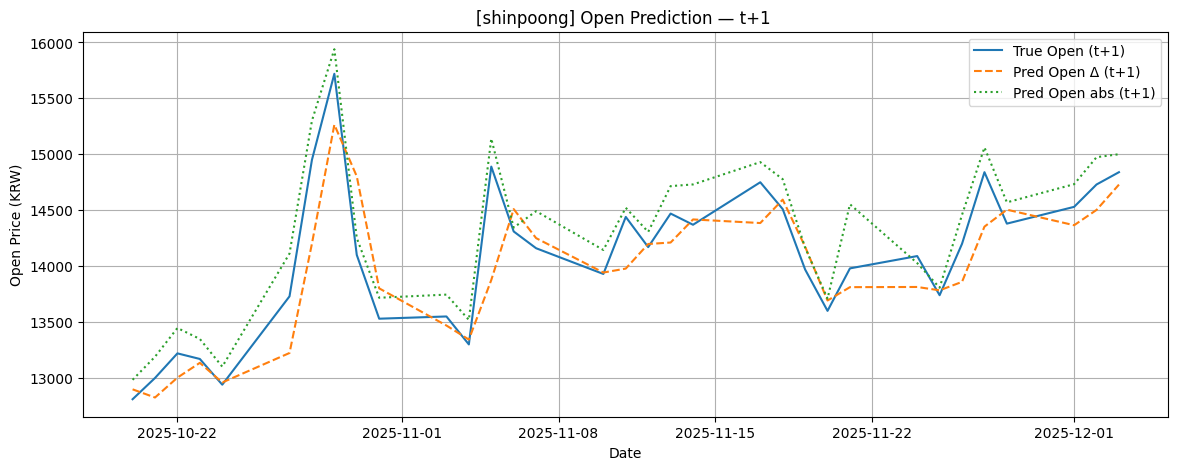

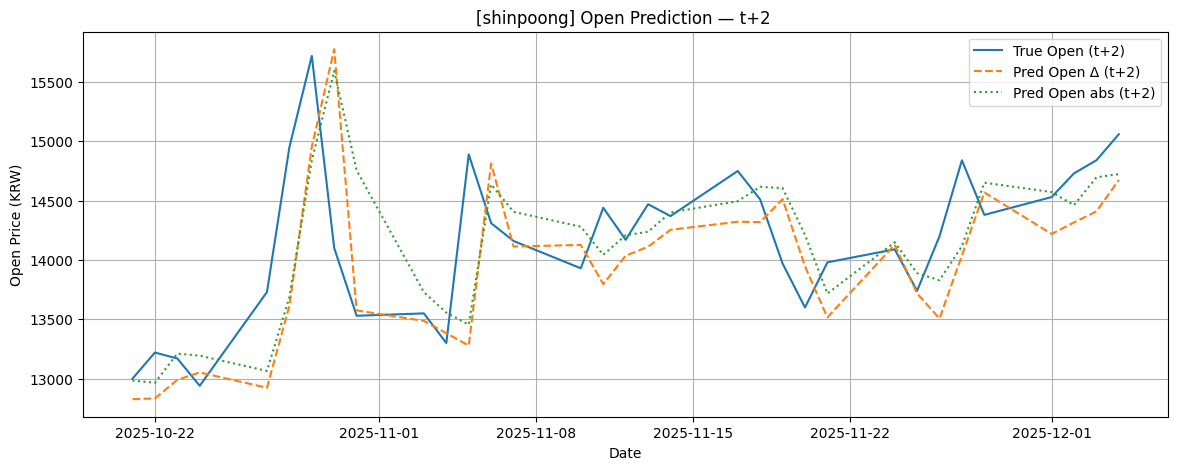

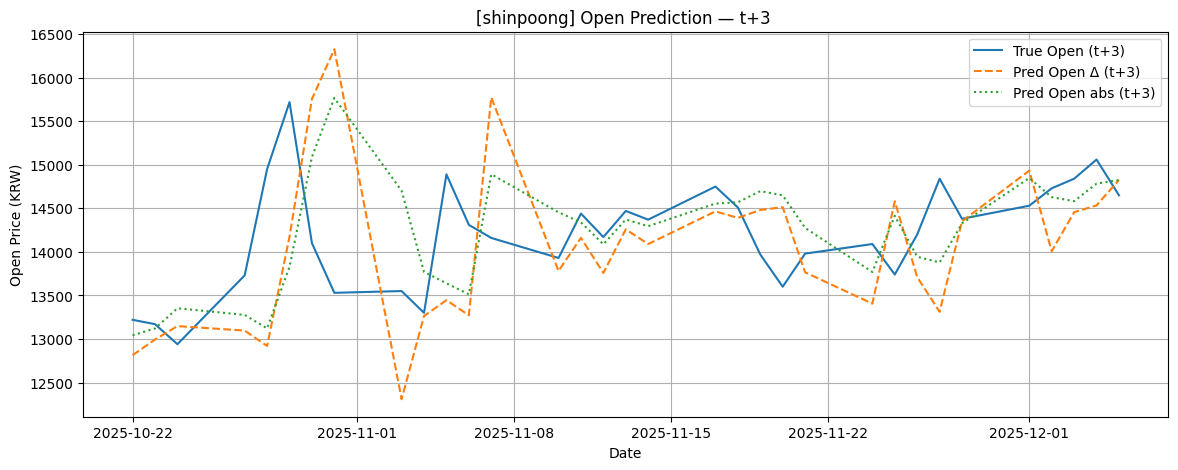

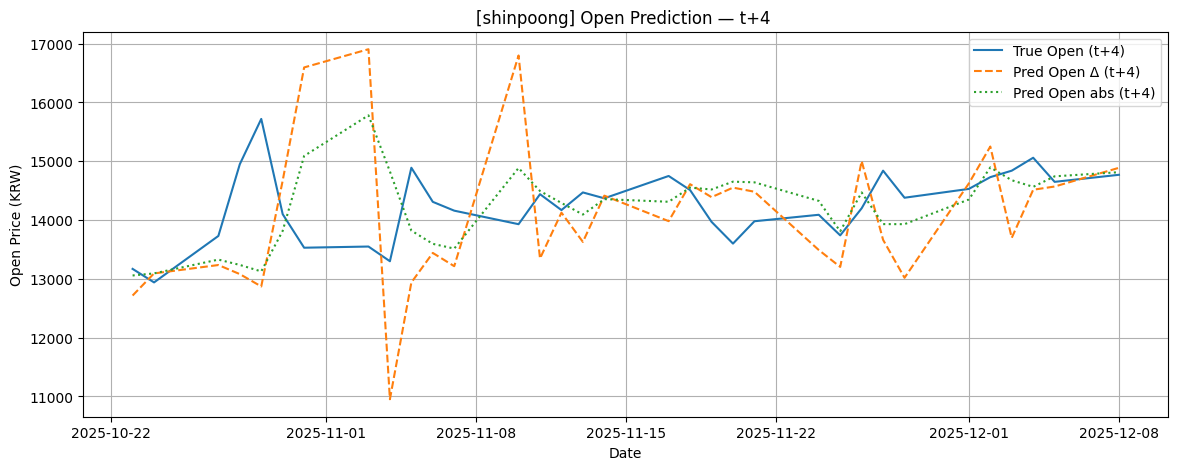

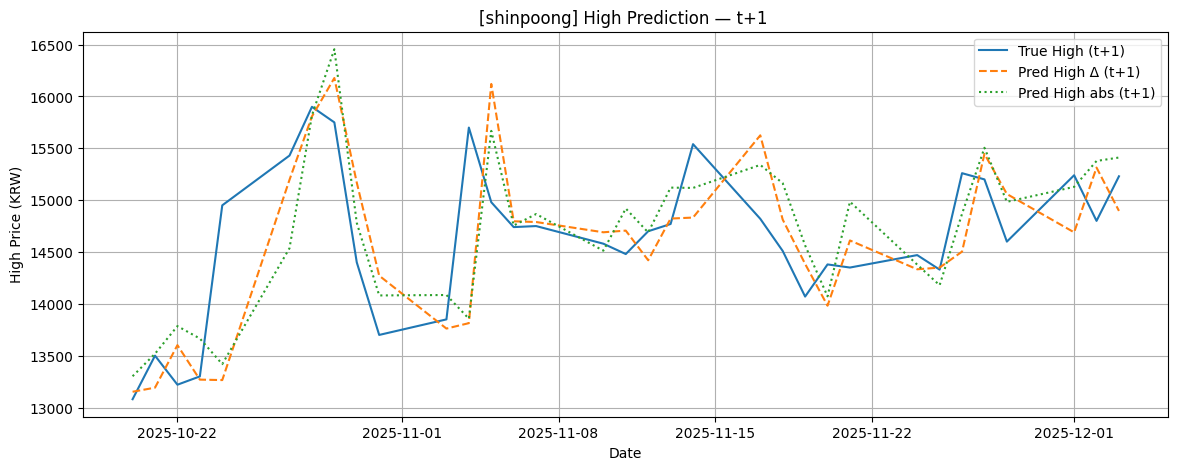

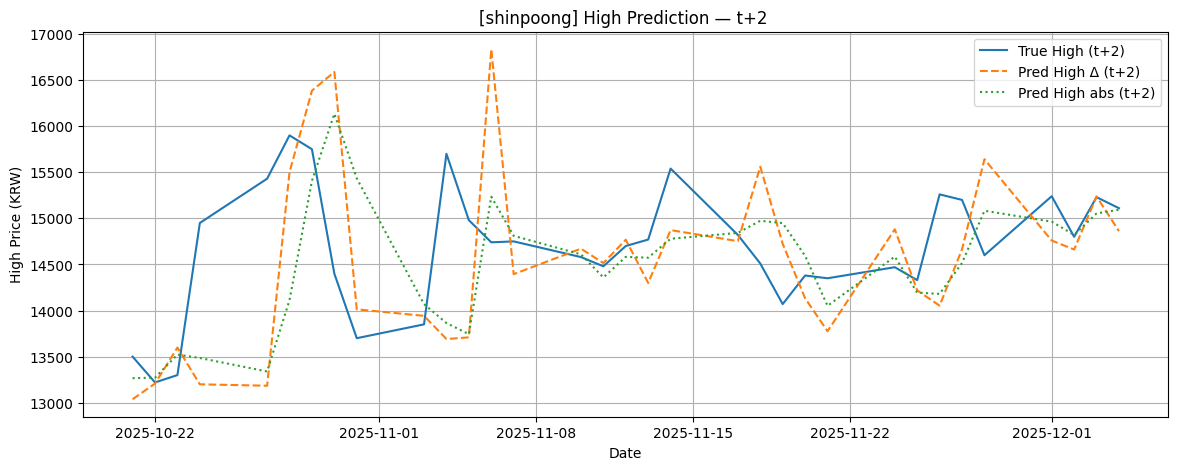

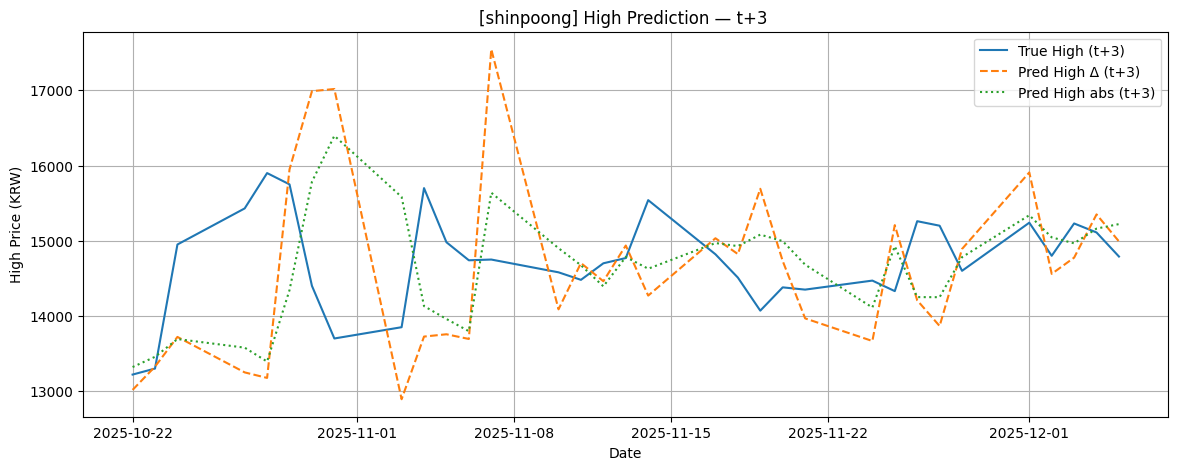

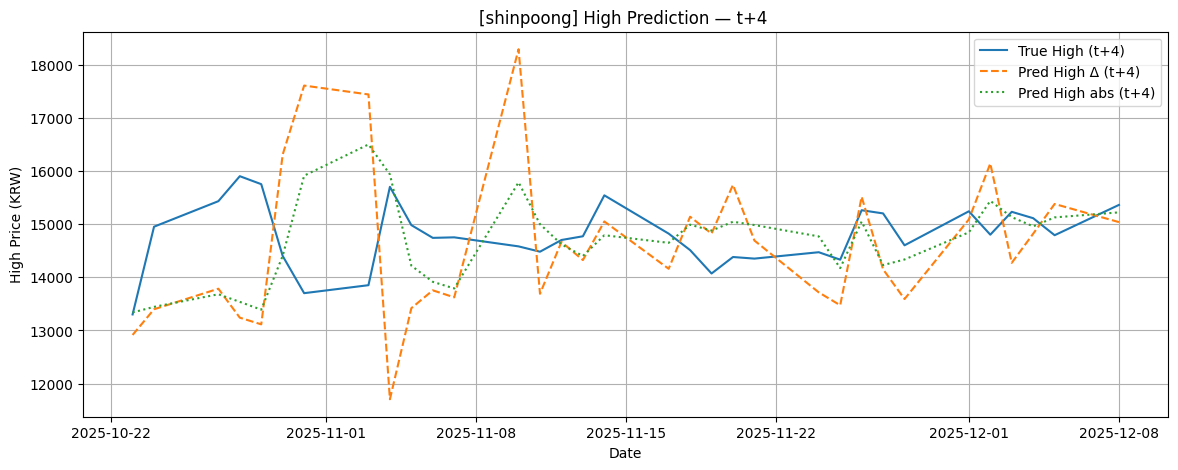

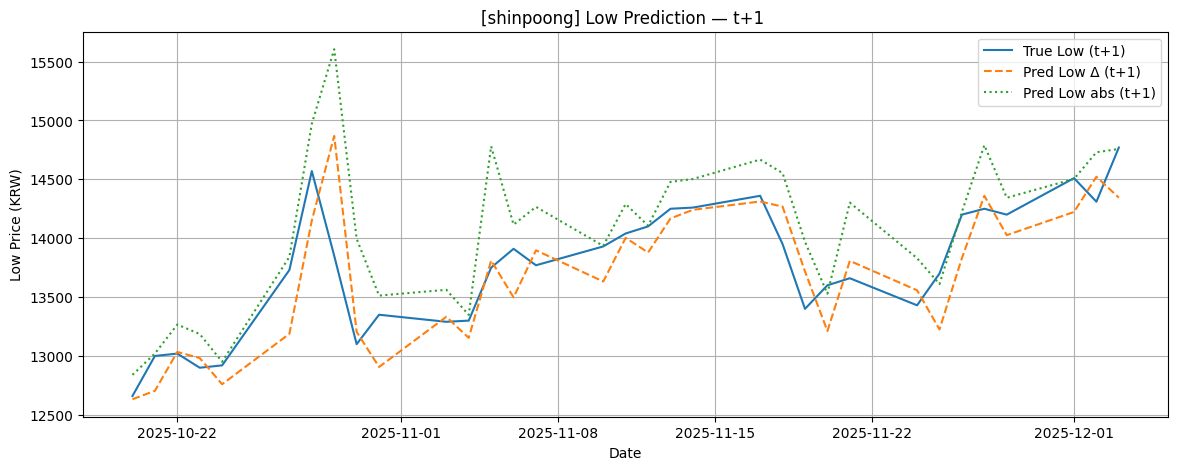

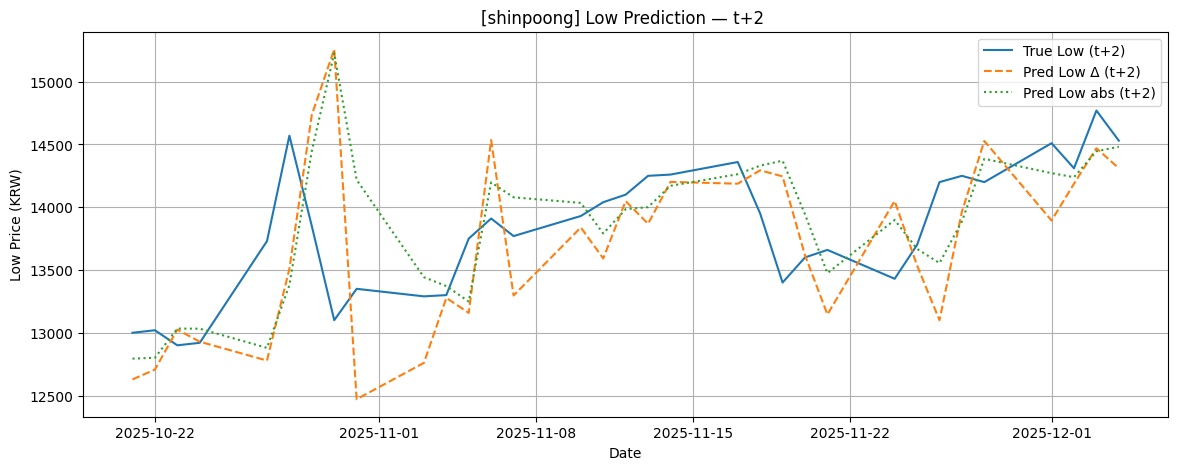

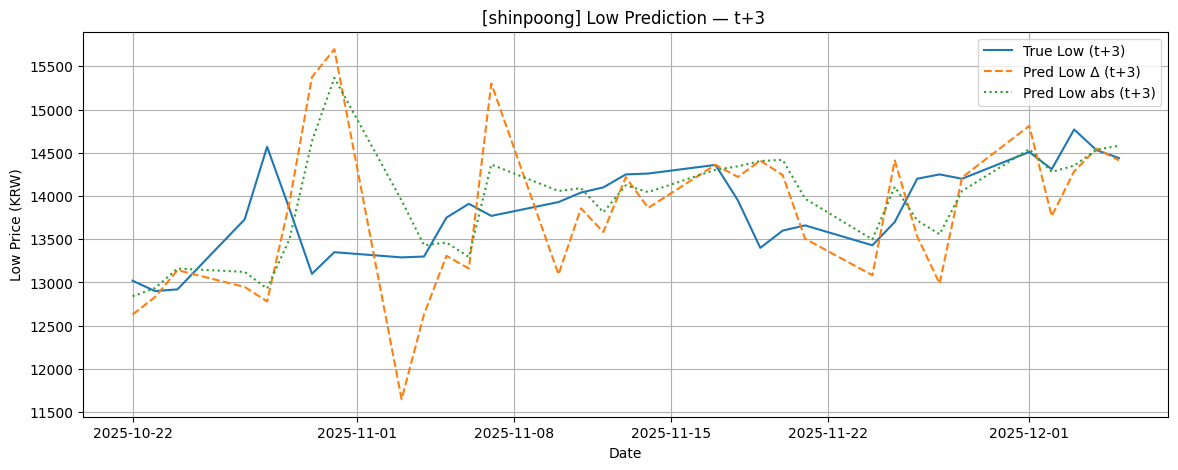

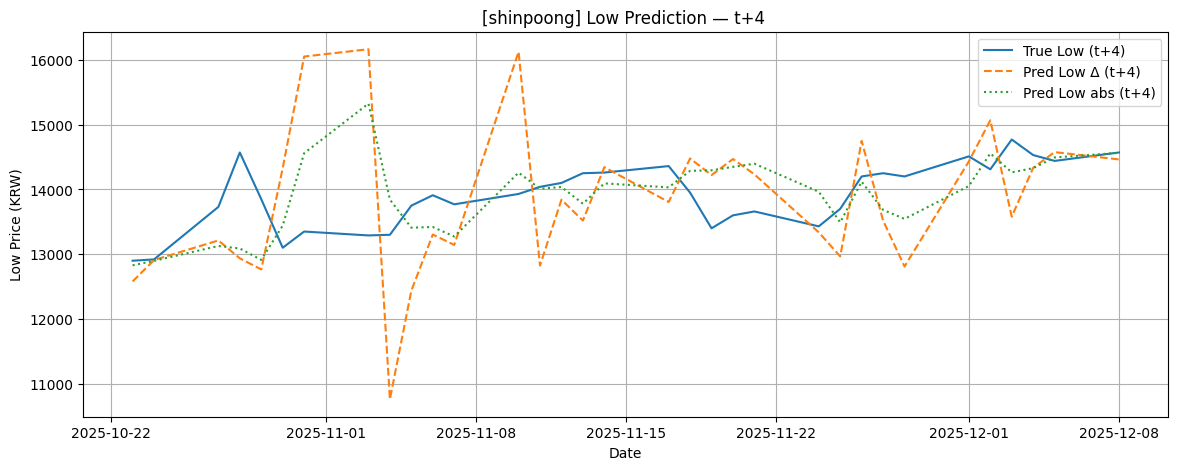

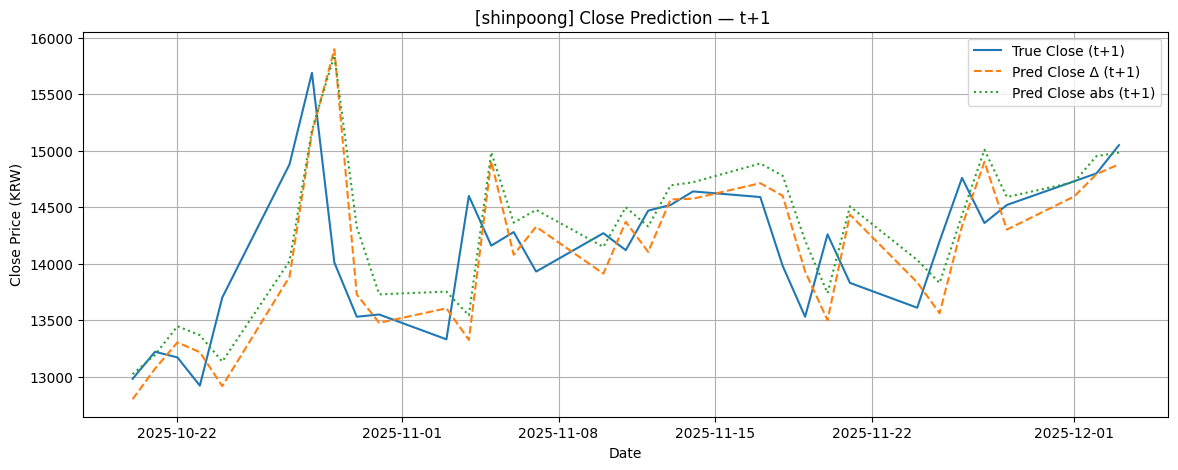

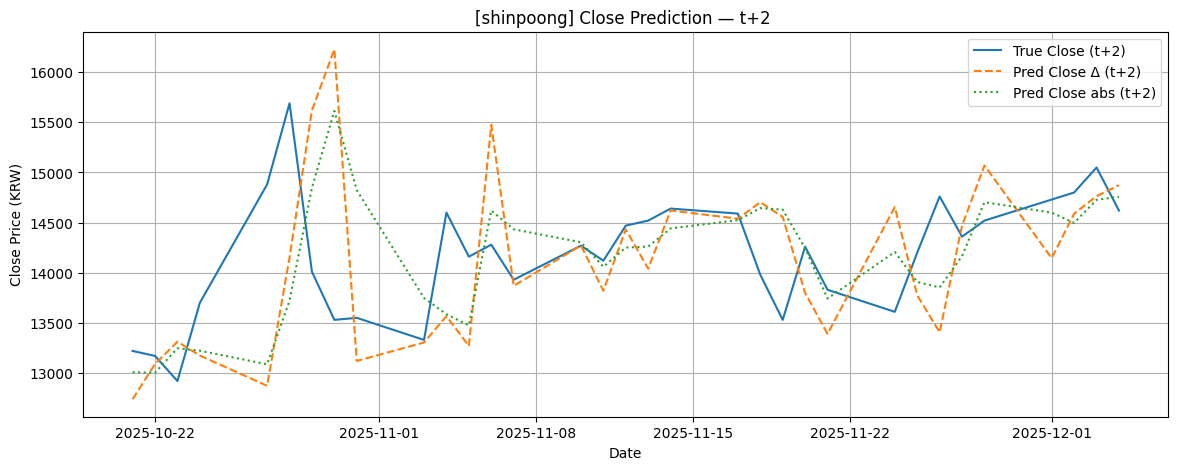

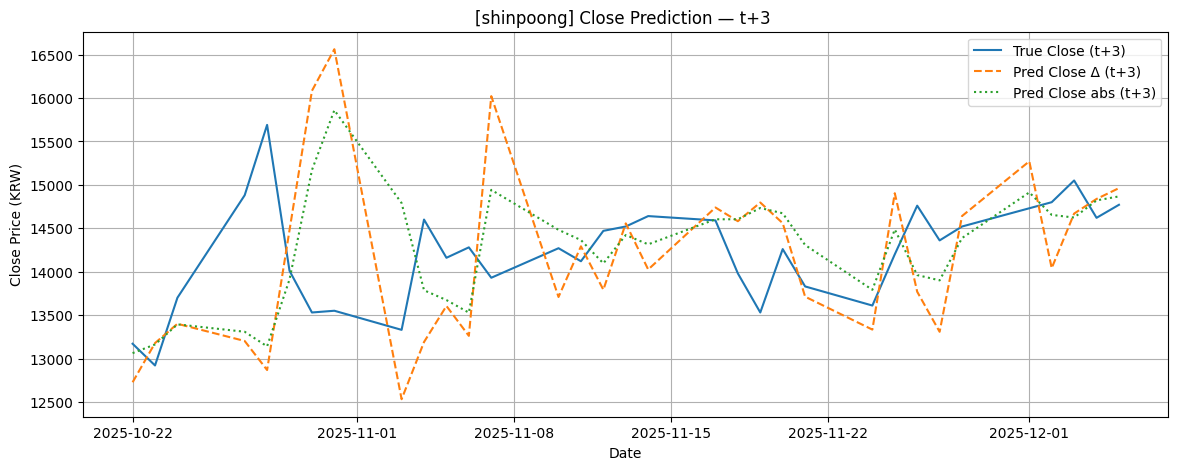

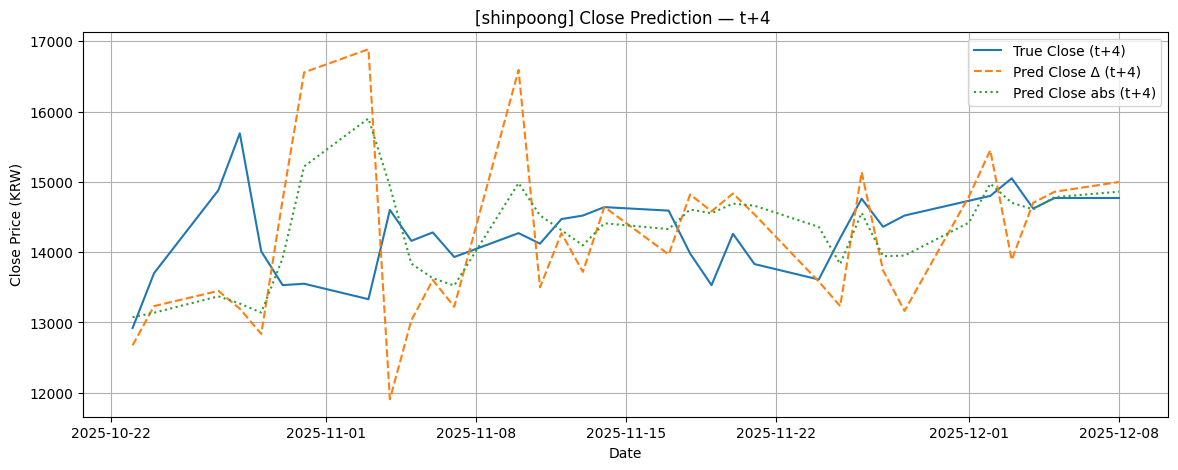

[robostar] 테스트 예측 & 시각화
  t+1 Close RMSE (Δ기반, 원):      5574.18
  Baseline RMSE (오늘 복사):        4723.96


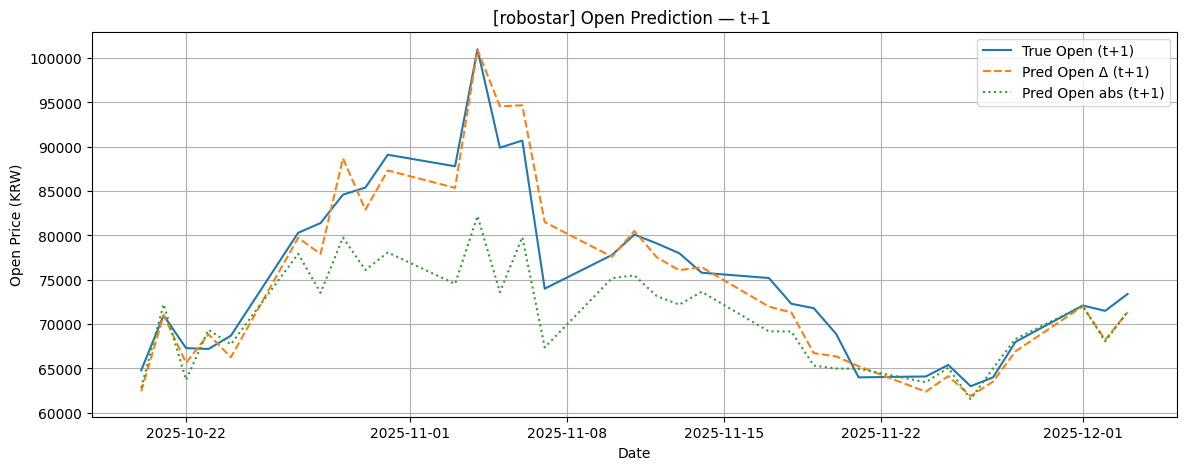

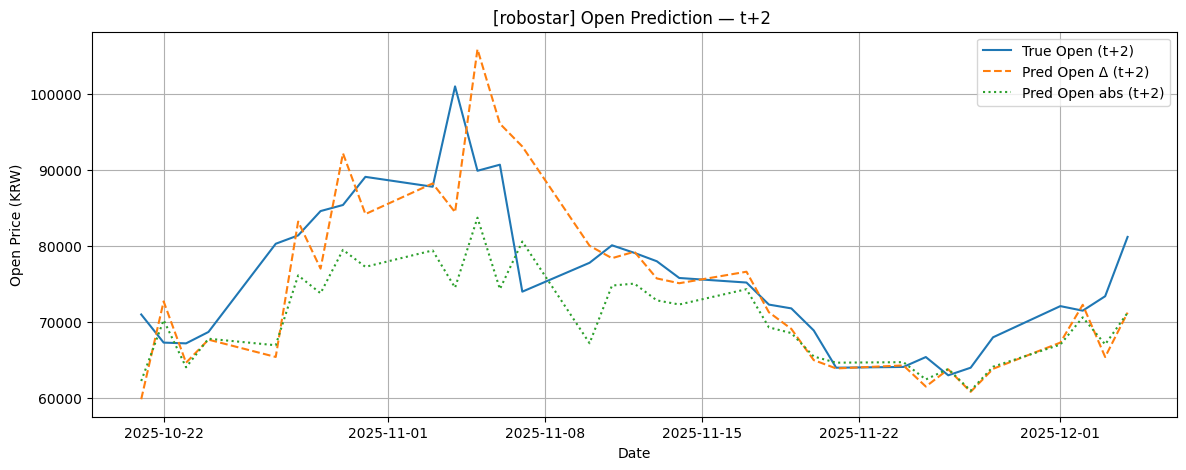

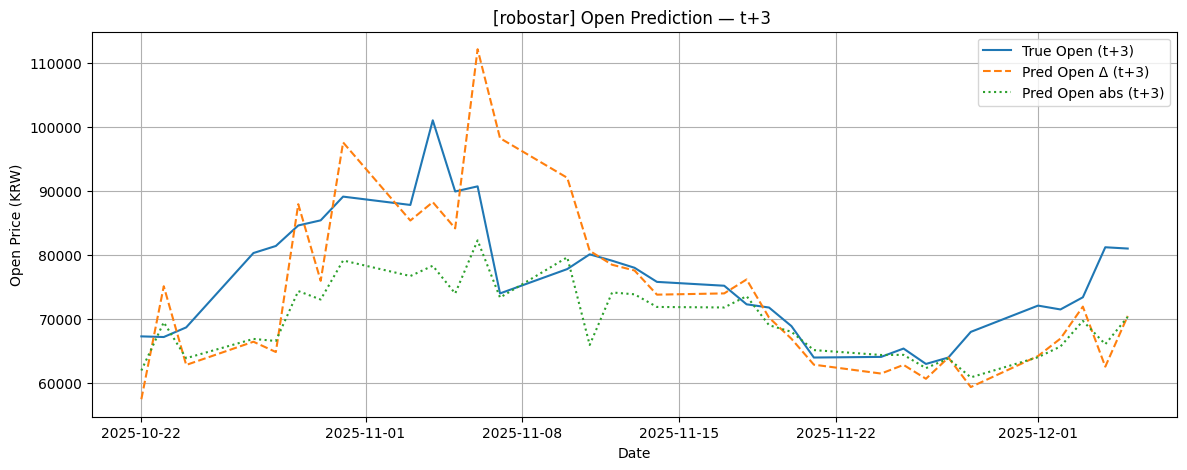

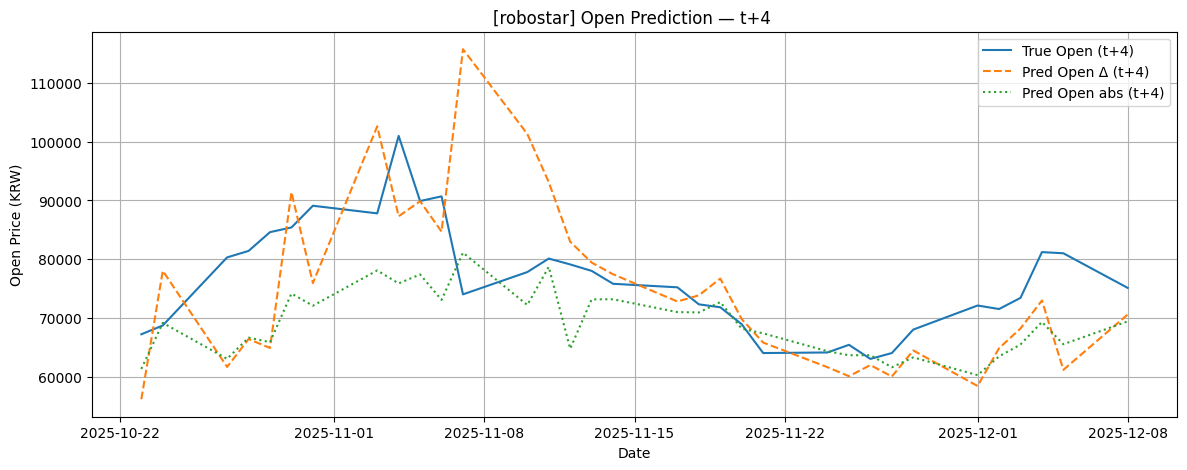

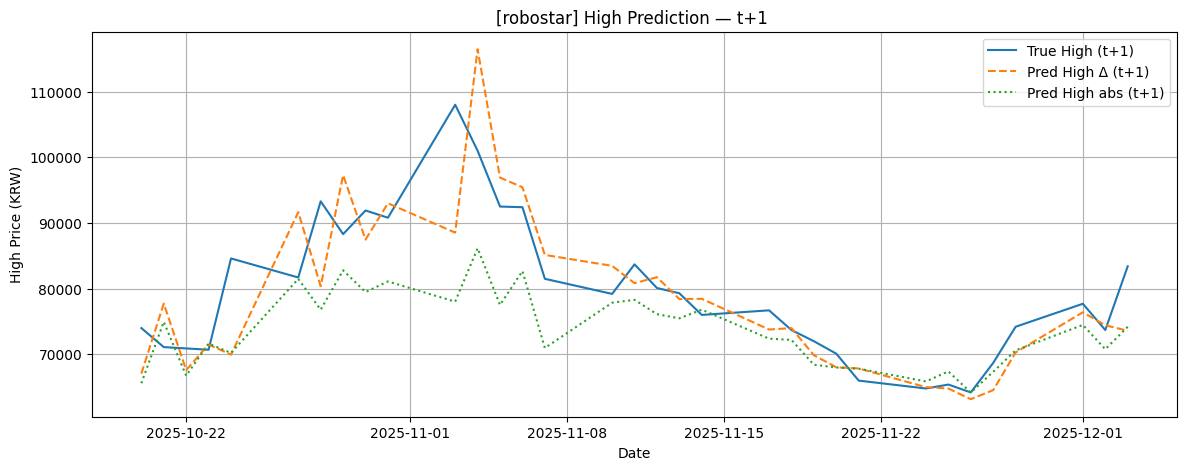

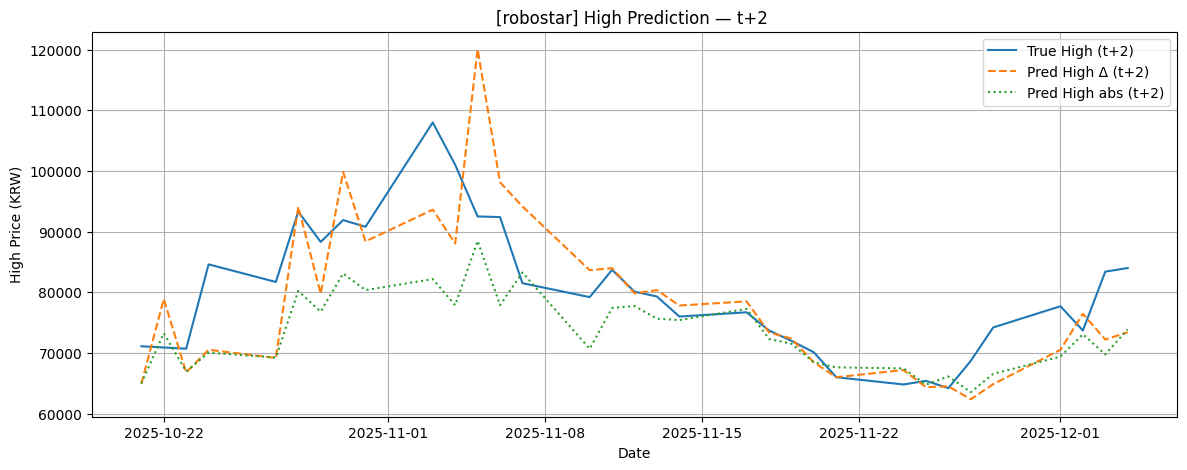

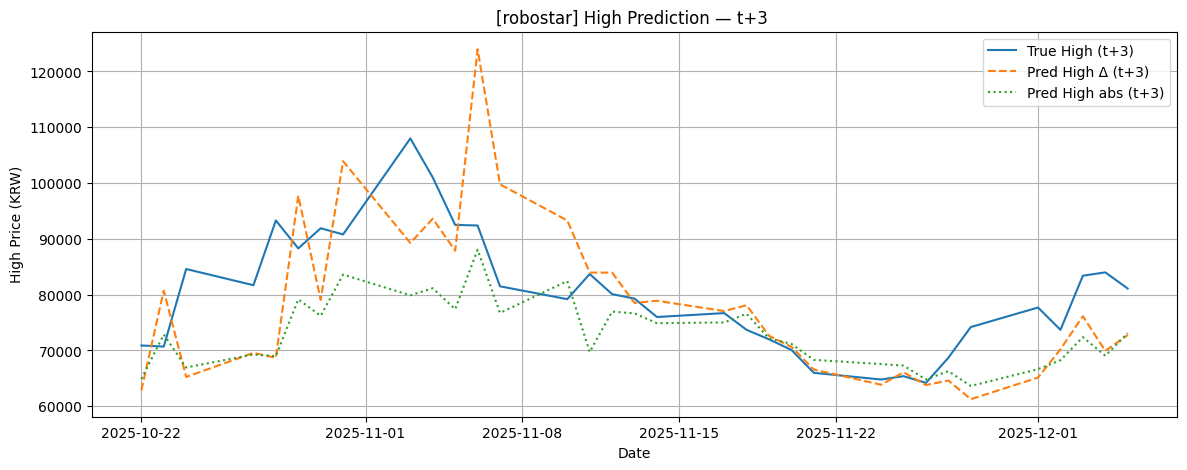

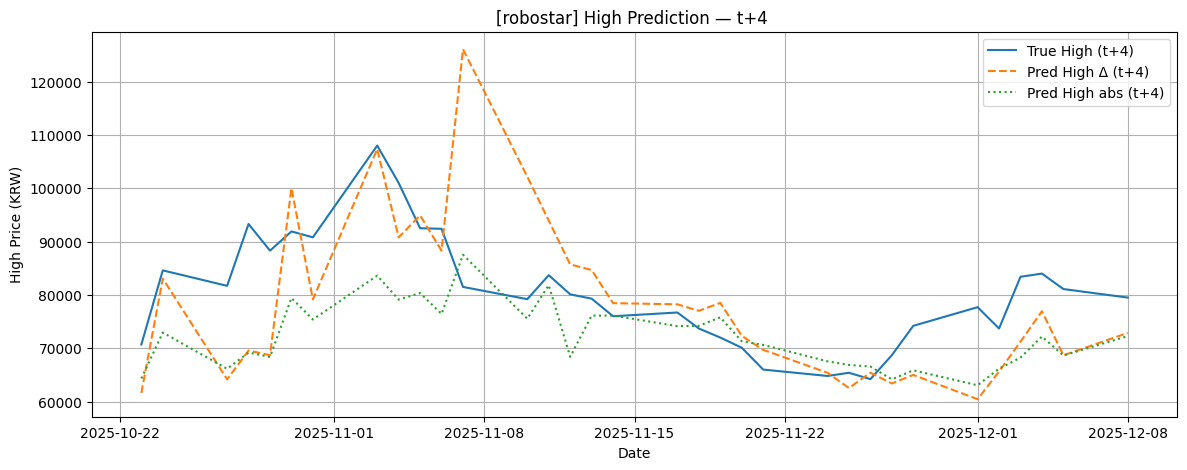

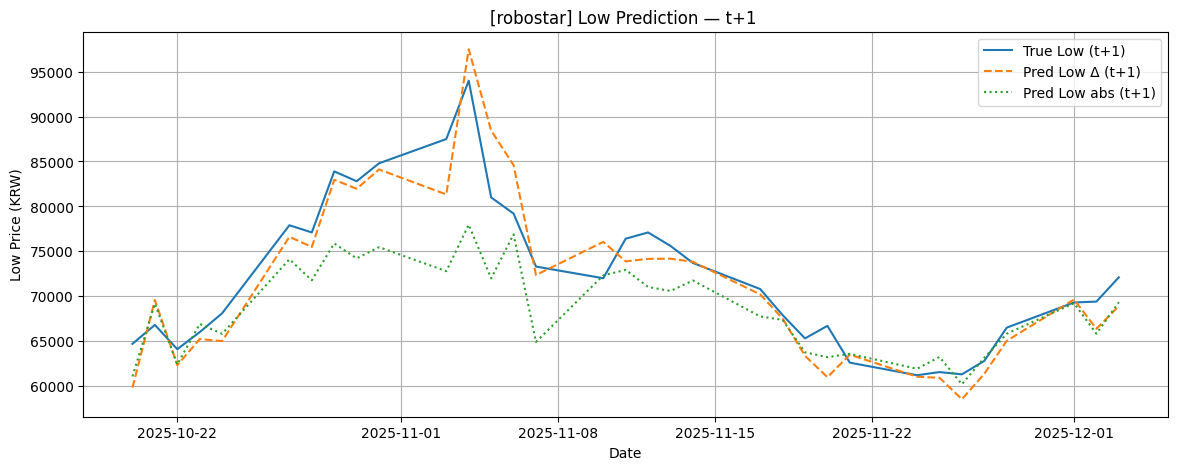

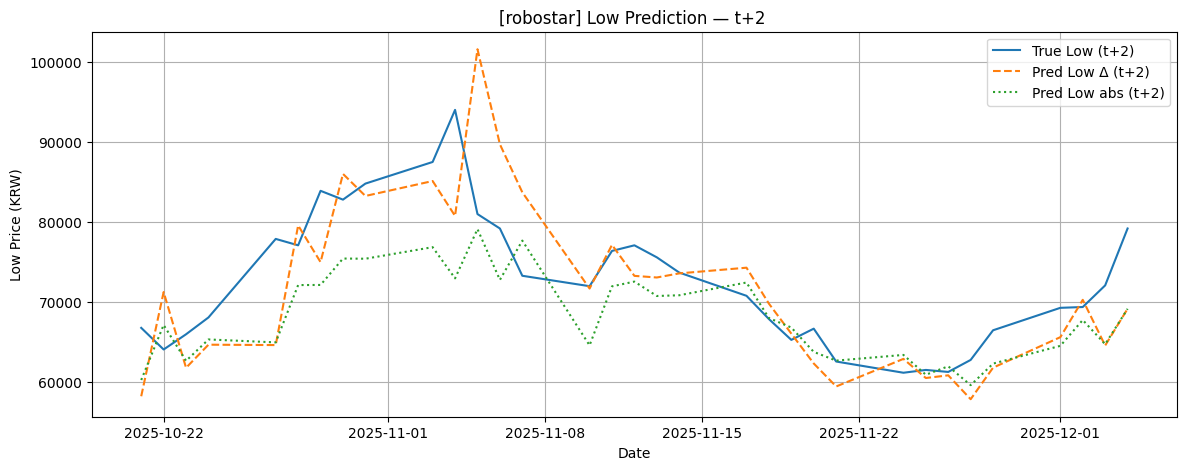

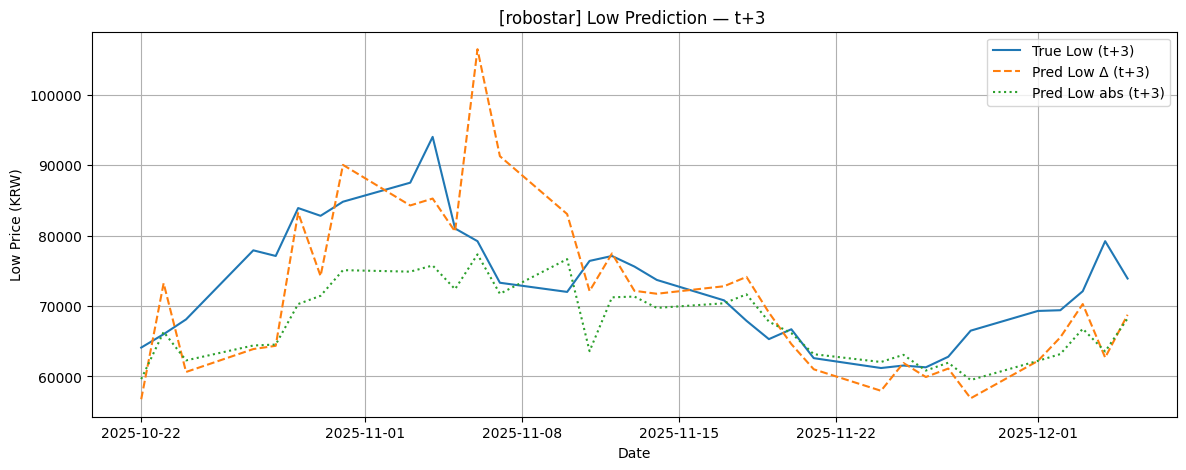

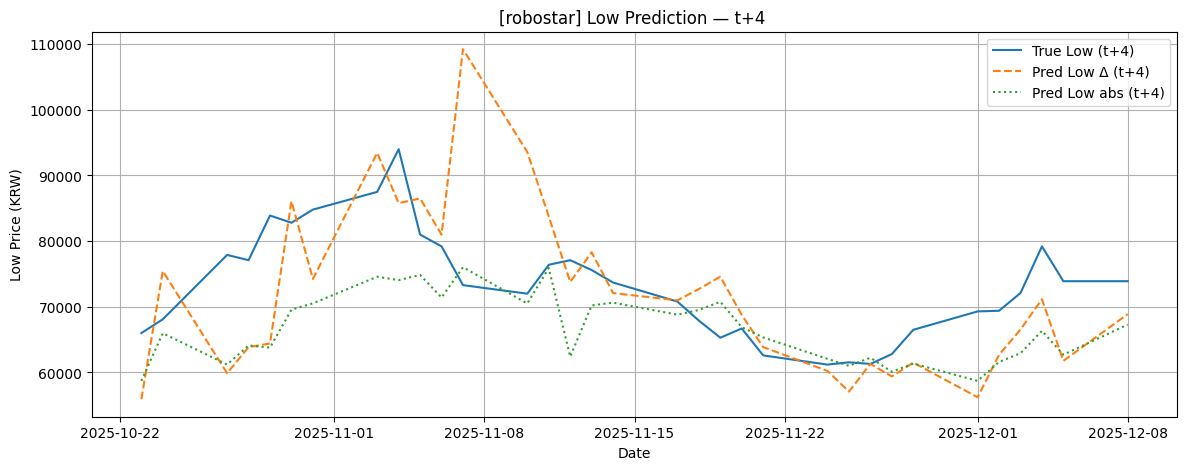

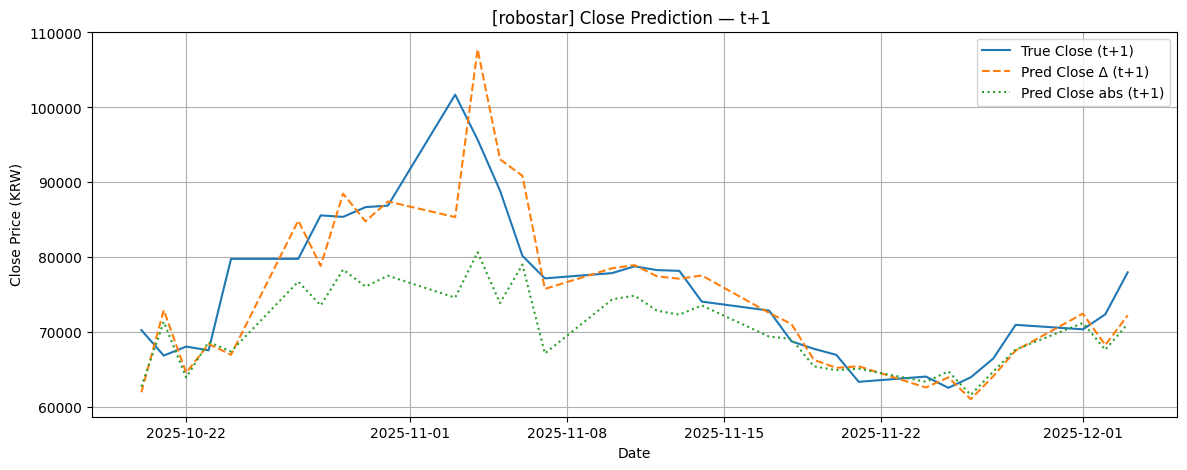

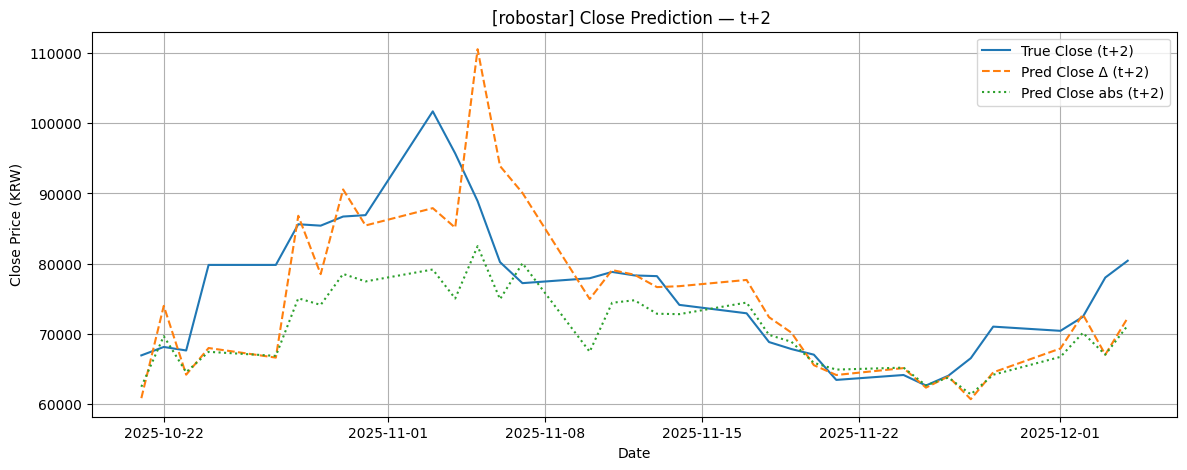

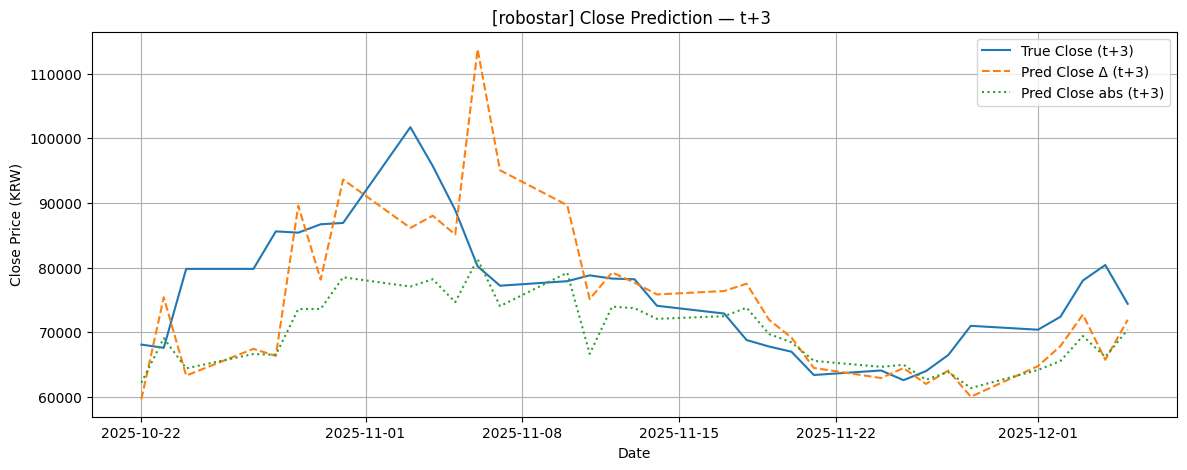

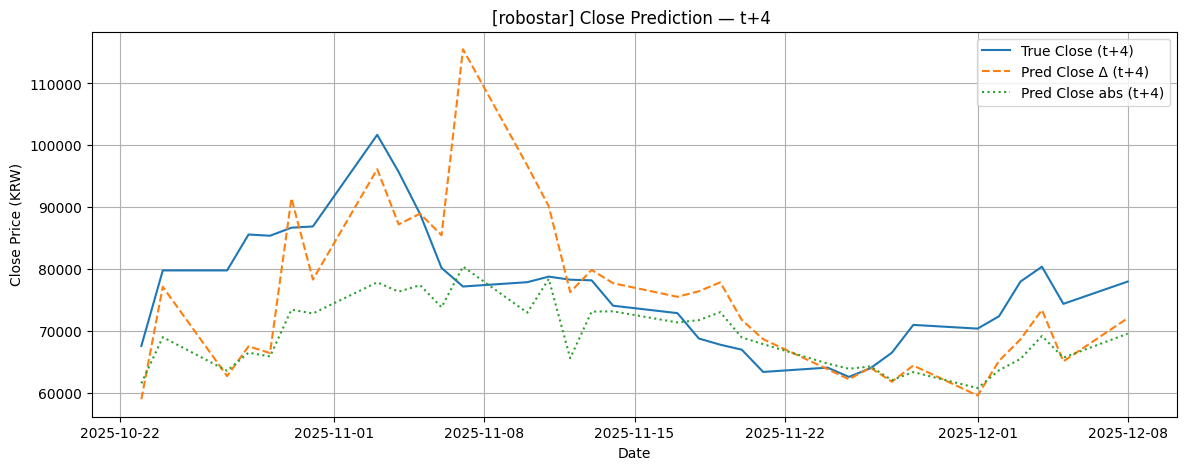

[daihan] 테스트 예측 & 시각화
  t+1 Close RMSE (Δ기반, 원):      441.47
  Baseline RMSE (오늘 복사):        411.02


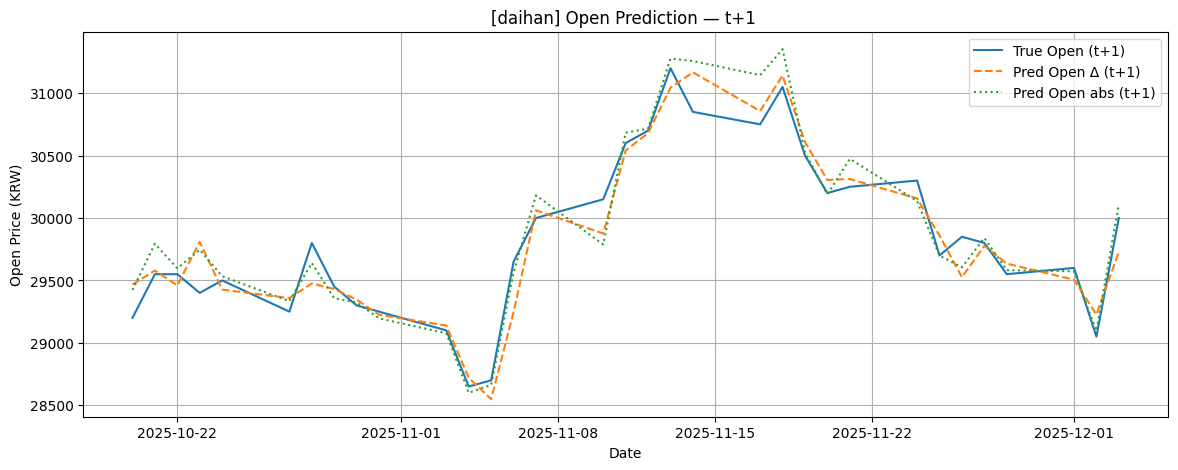

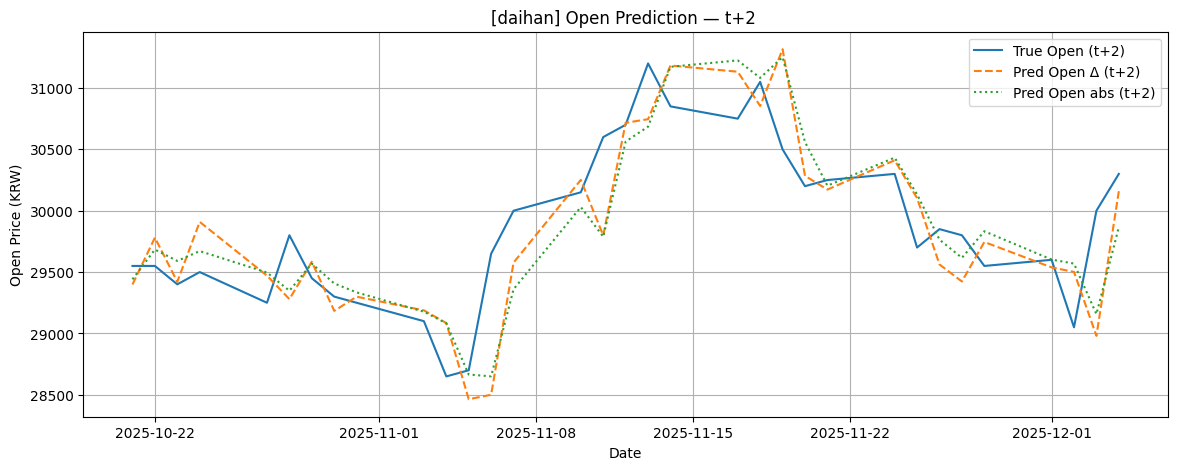

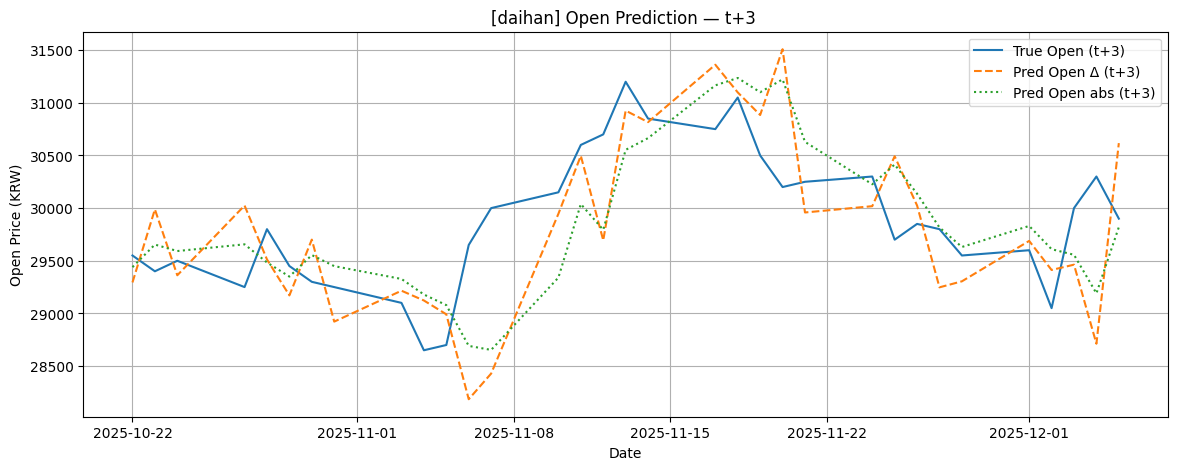

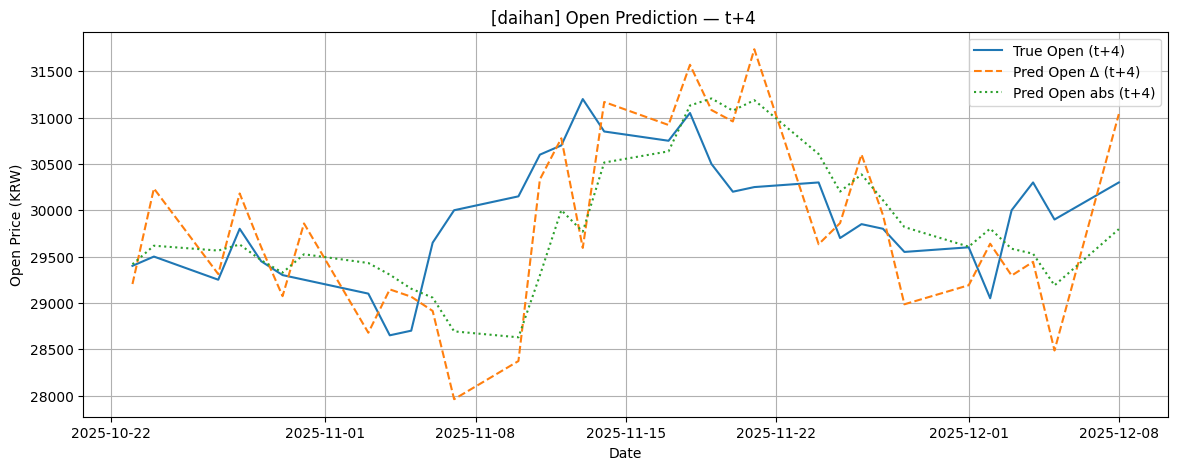

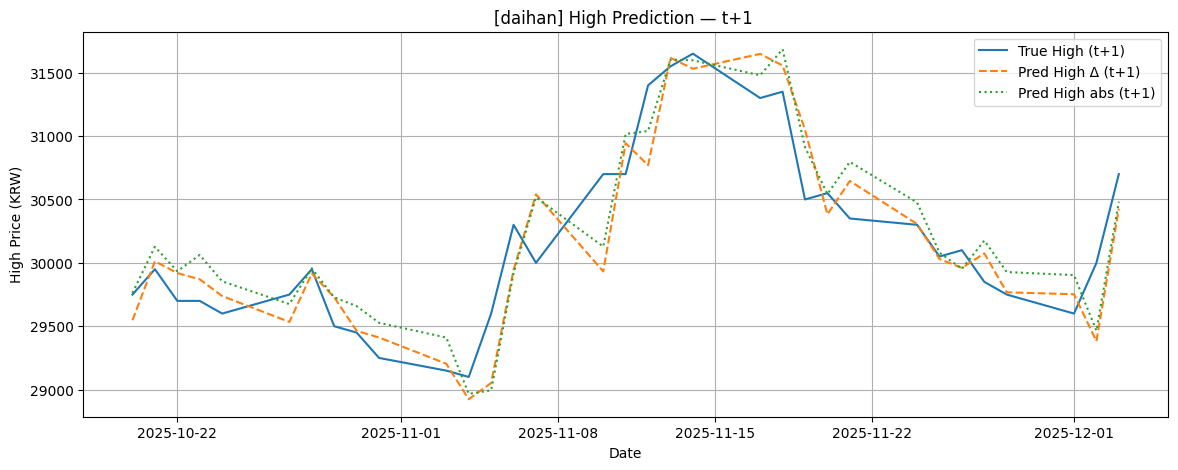

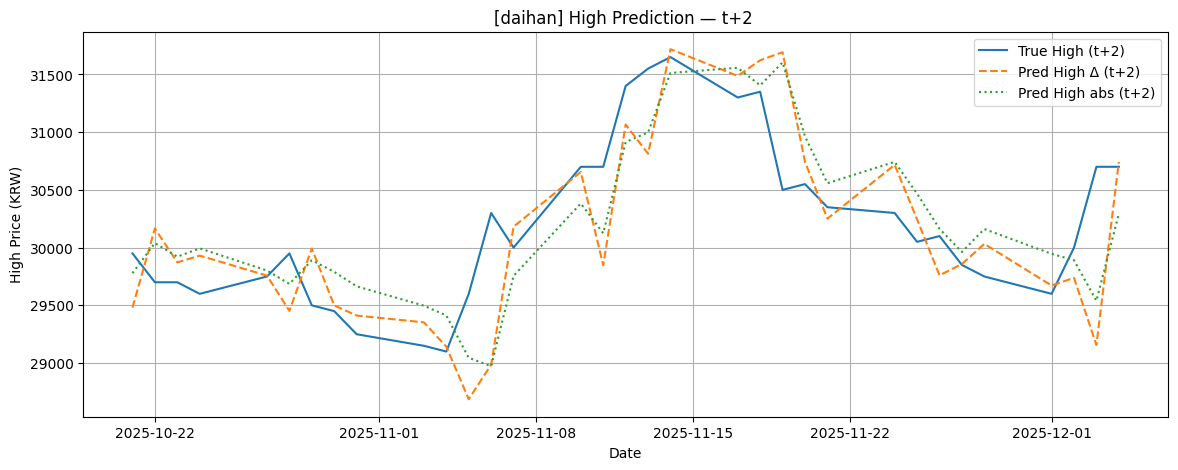

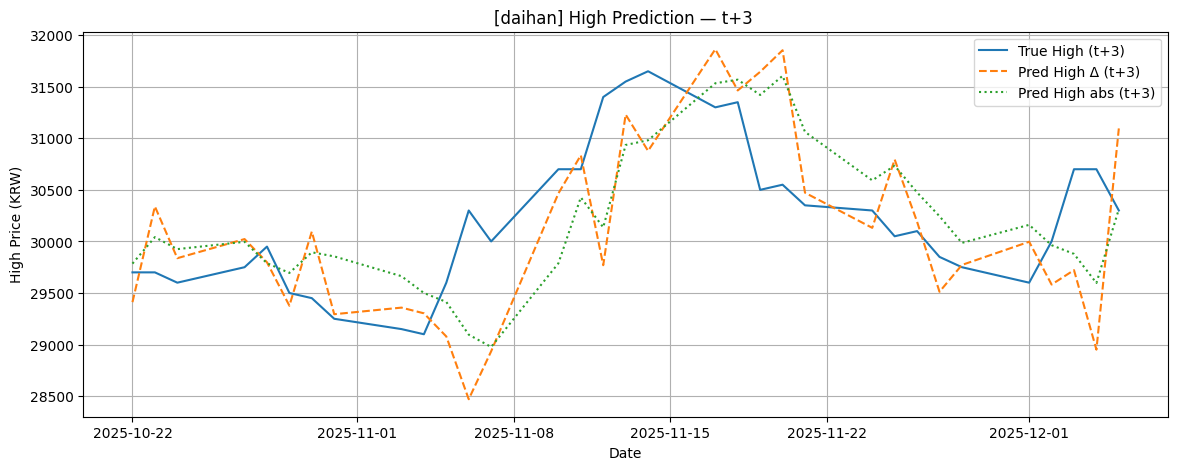

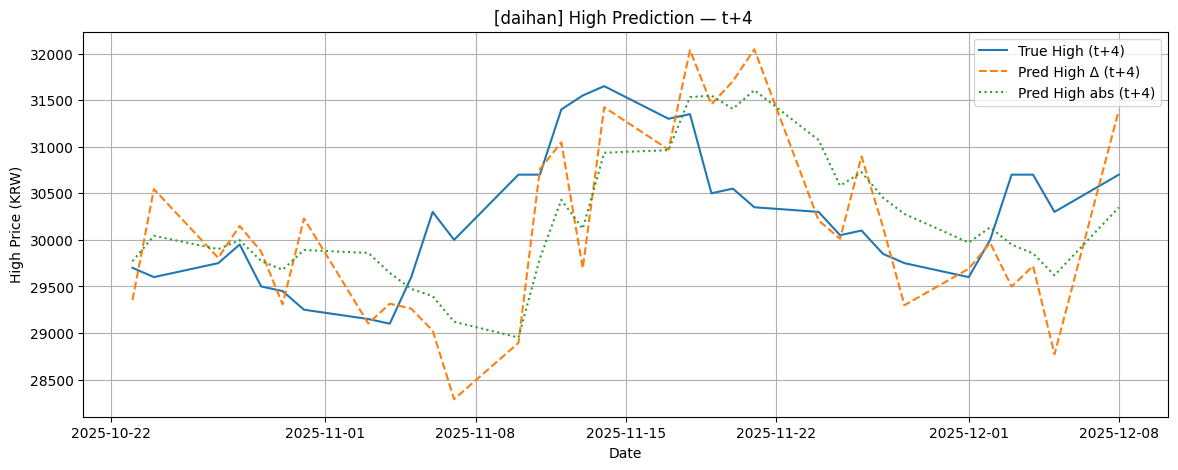

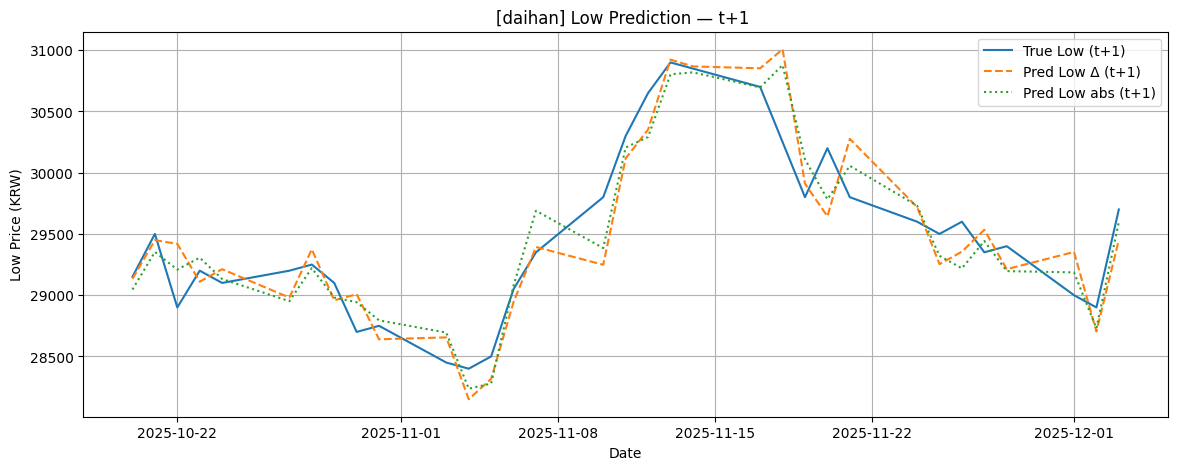

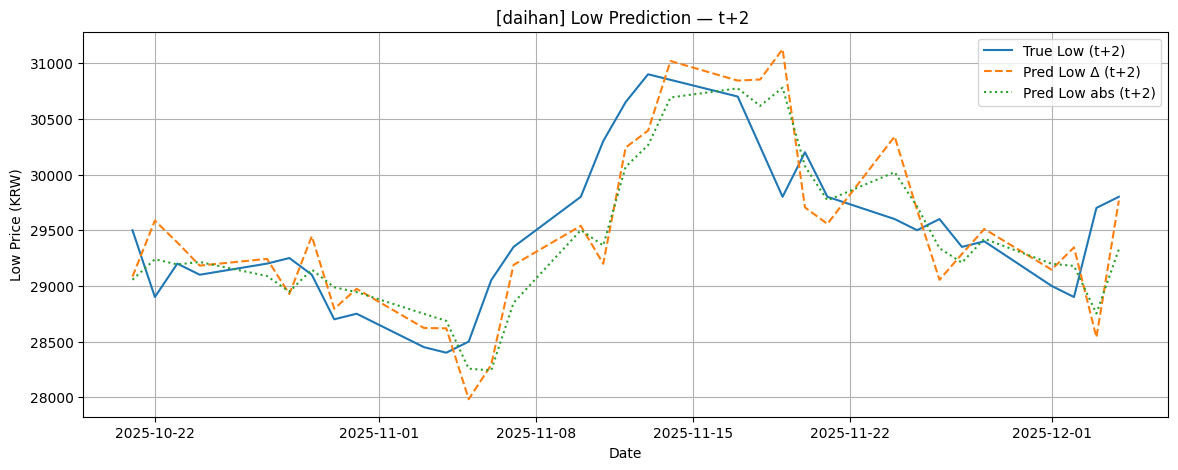

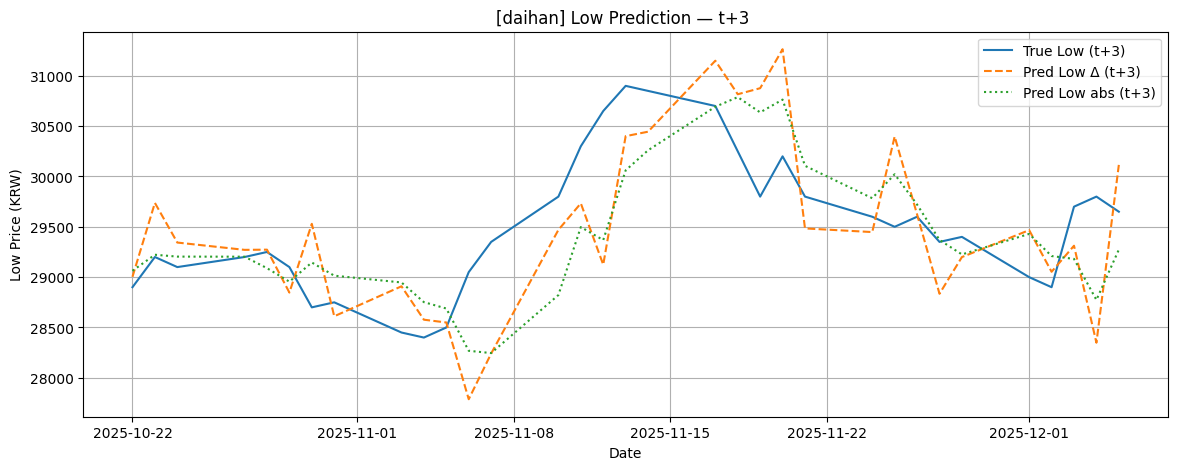

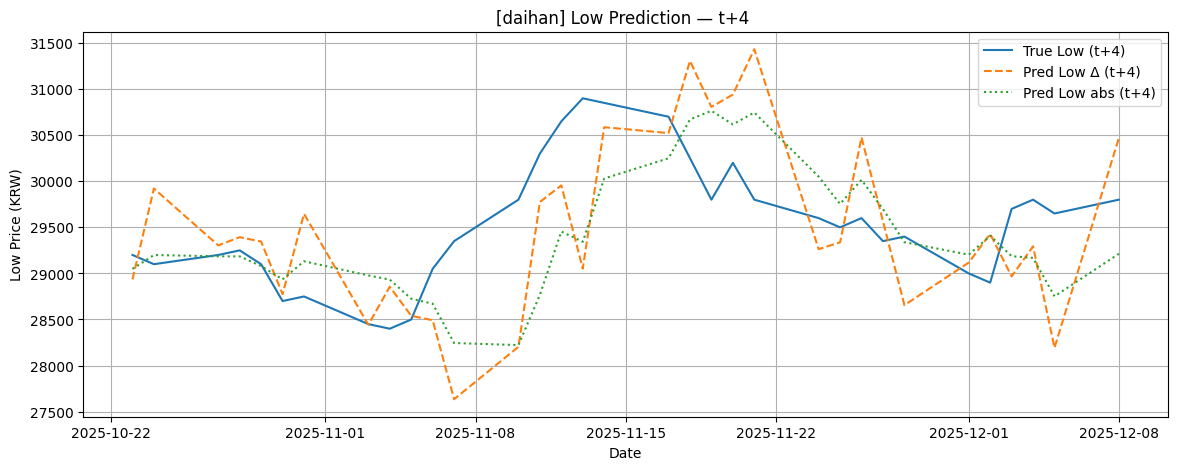

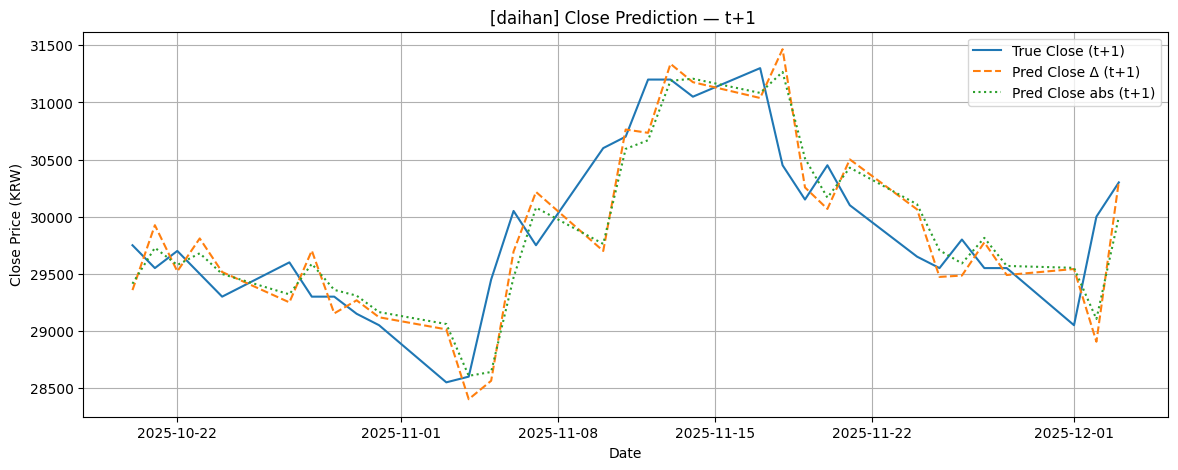

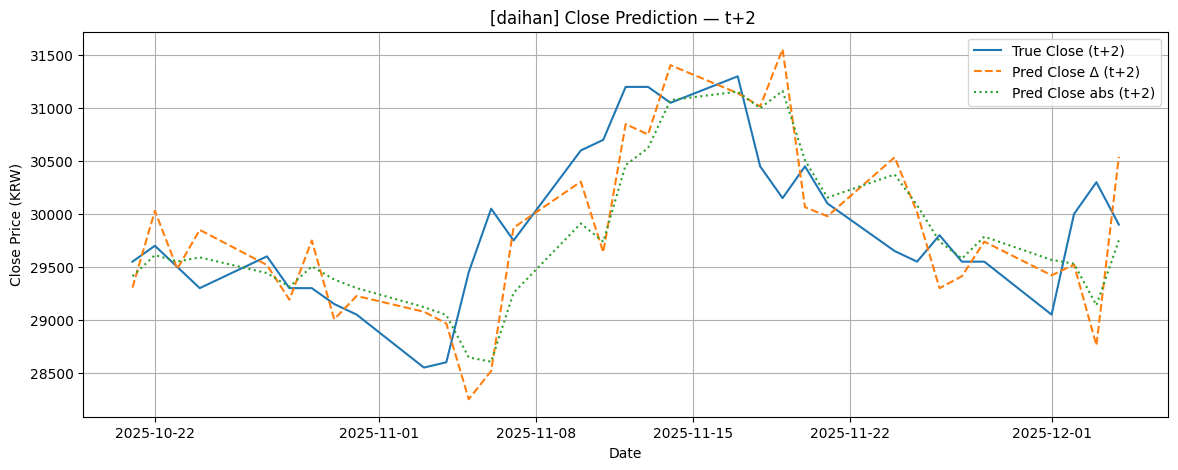

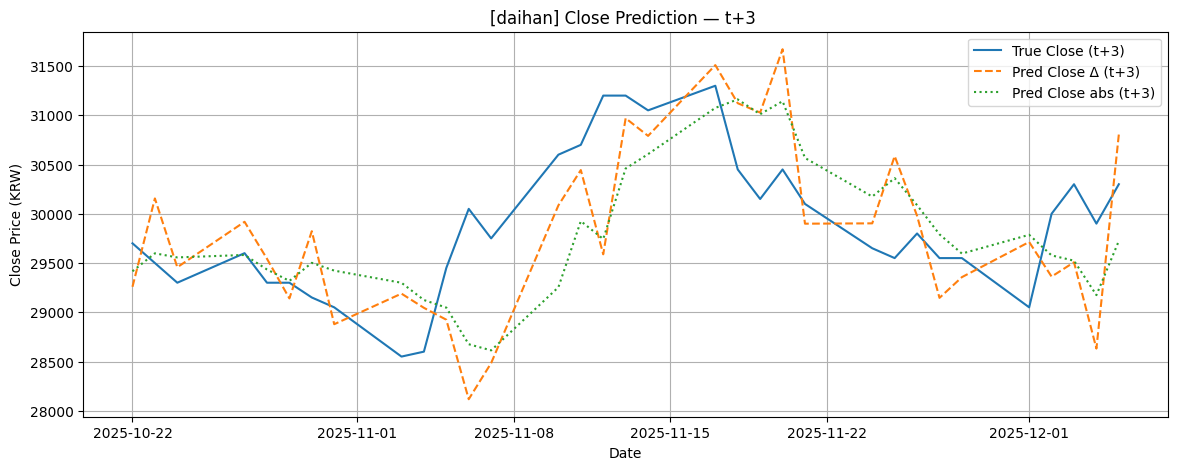

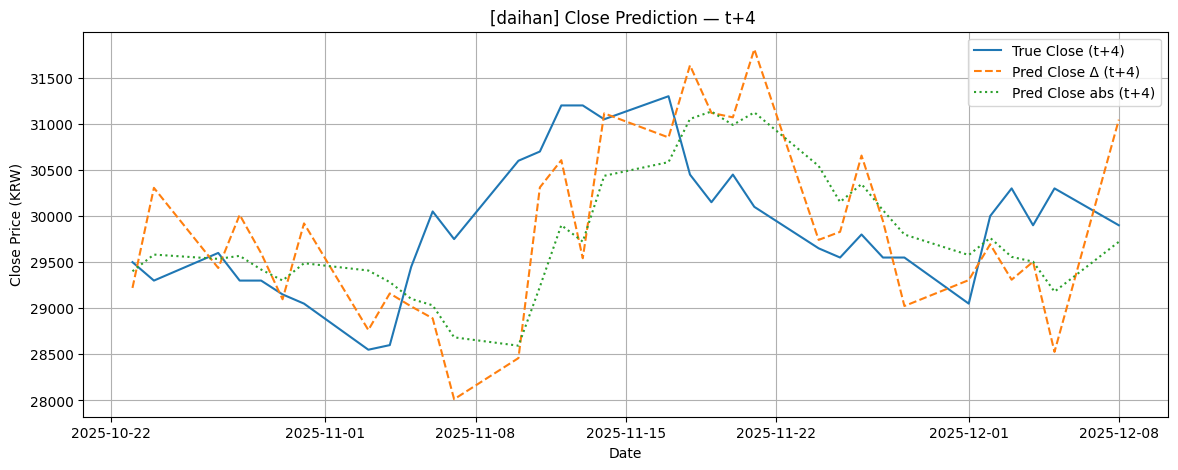

[dbhitek] 테스트 예측 & 시각화
  t+1 Close RMSE (Δ기반, 원):      2473.19
  Baseline RMSE (오늘 복사):        2607.27


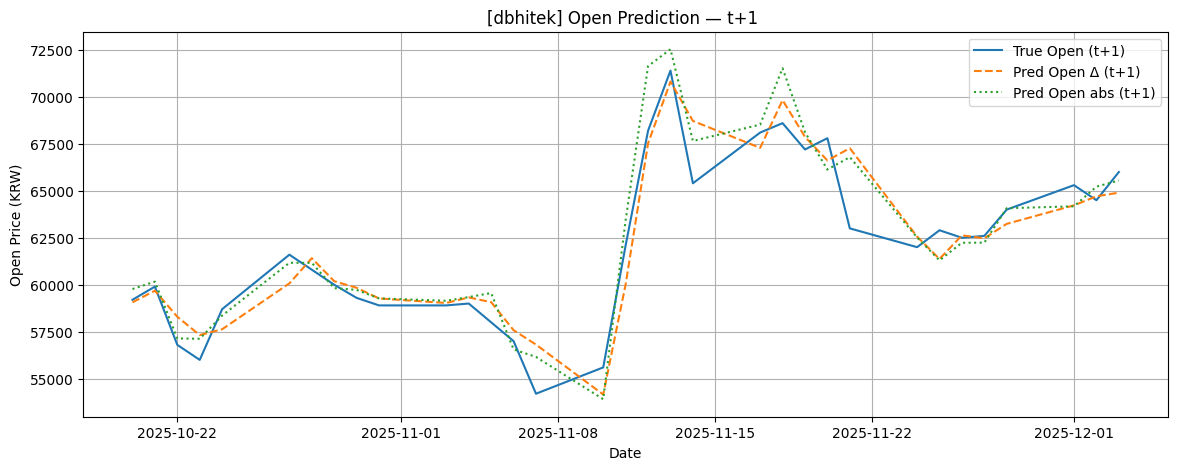

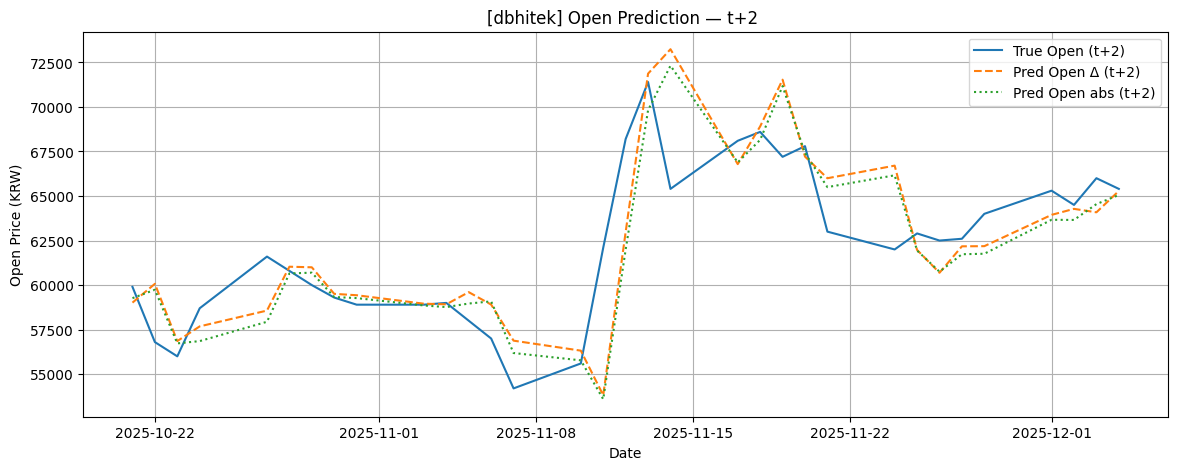

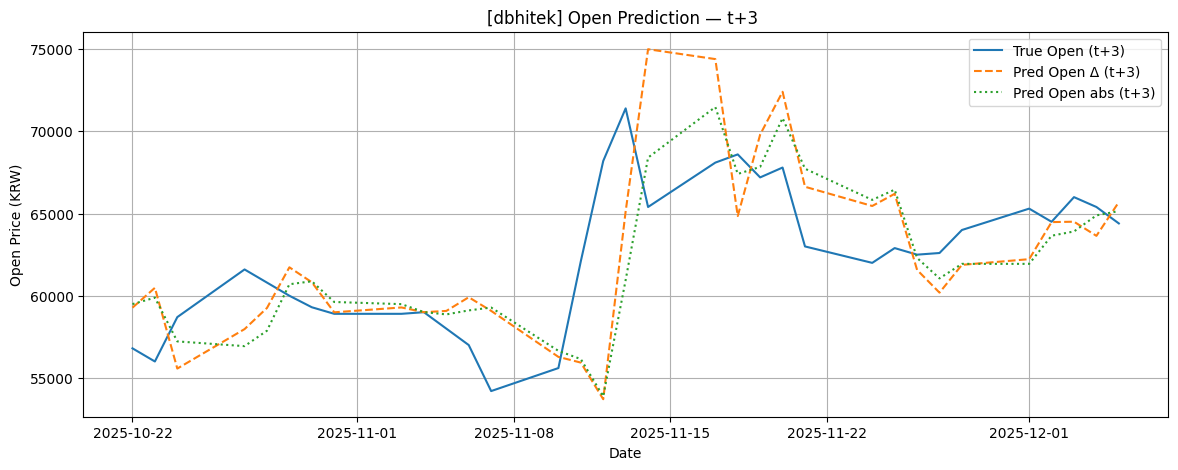

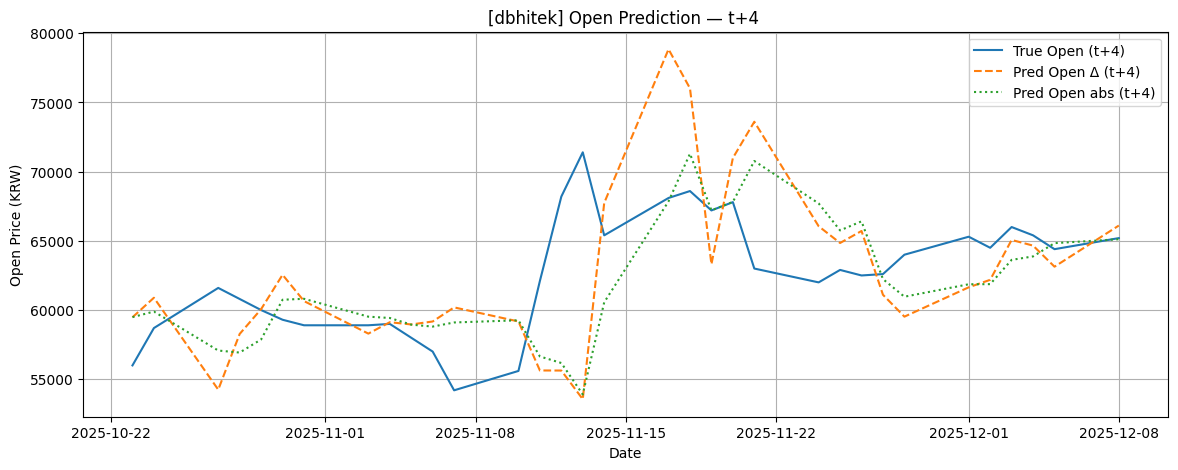

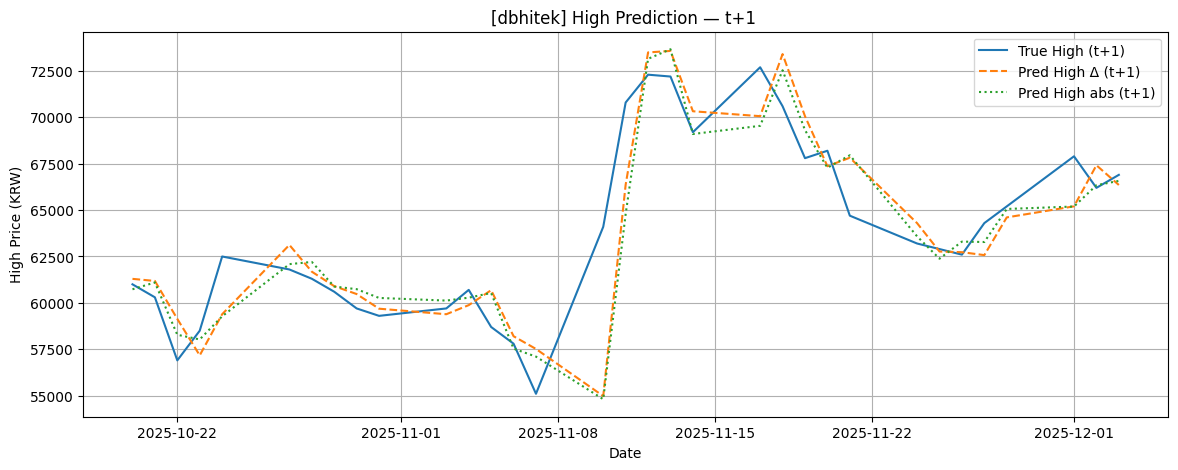

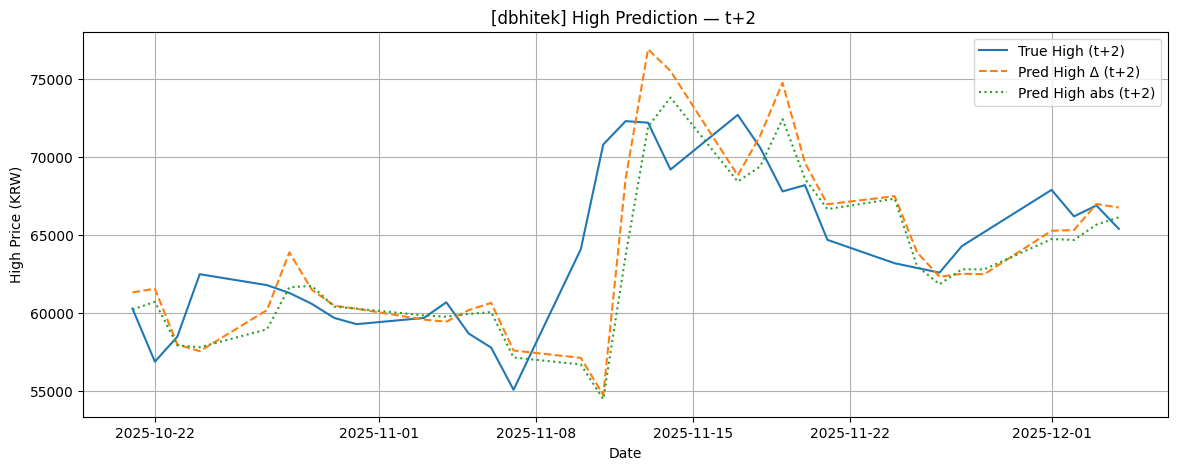

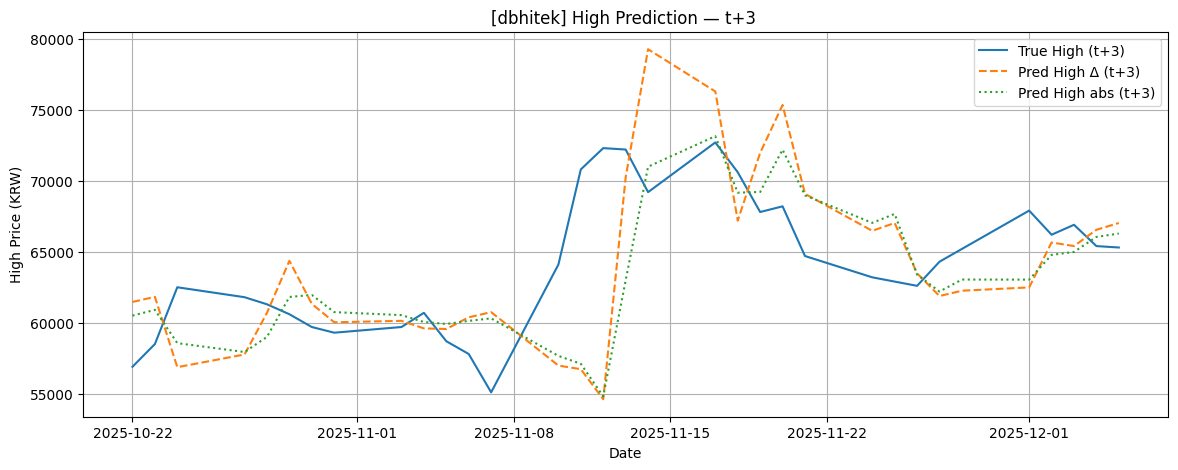

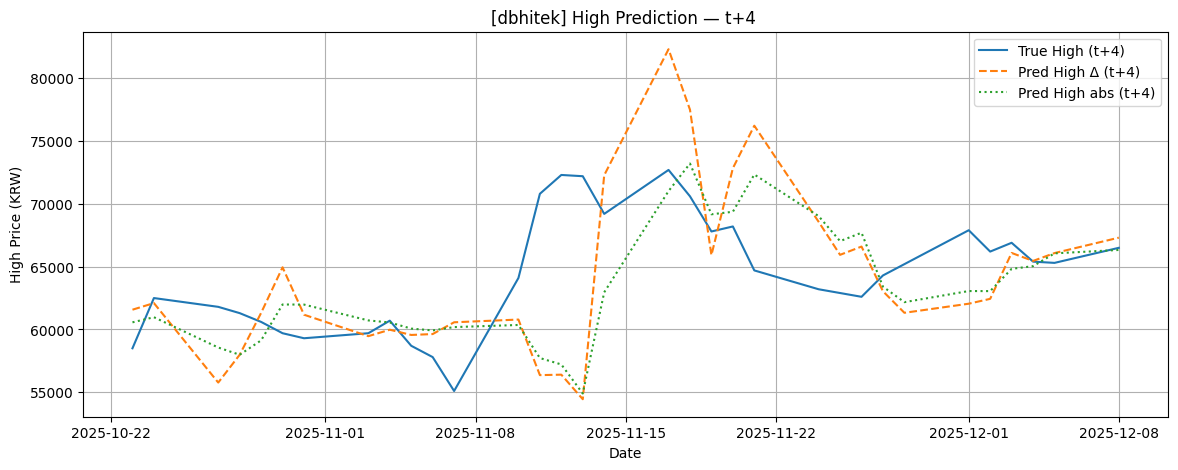

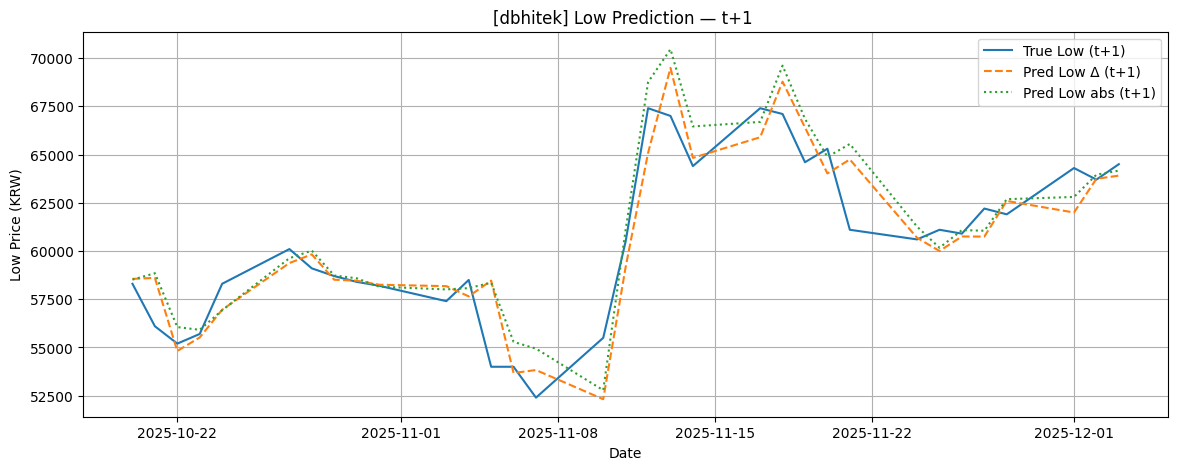

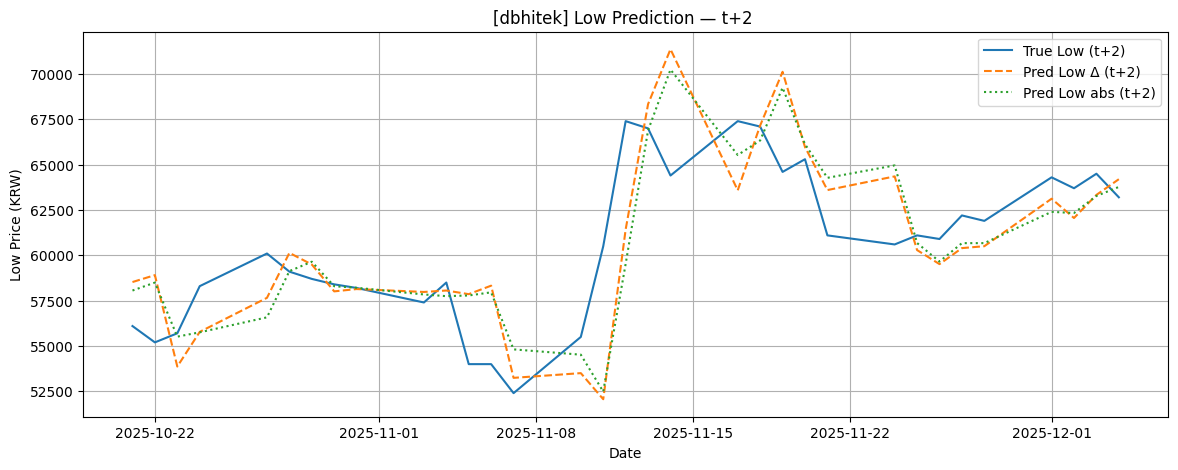

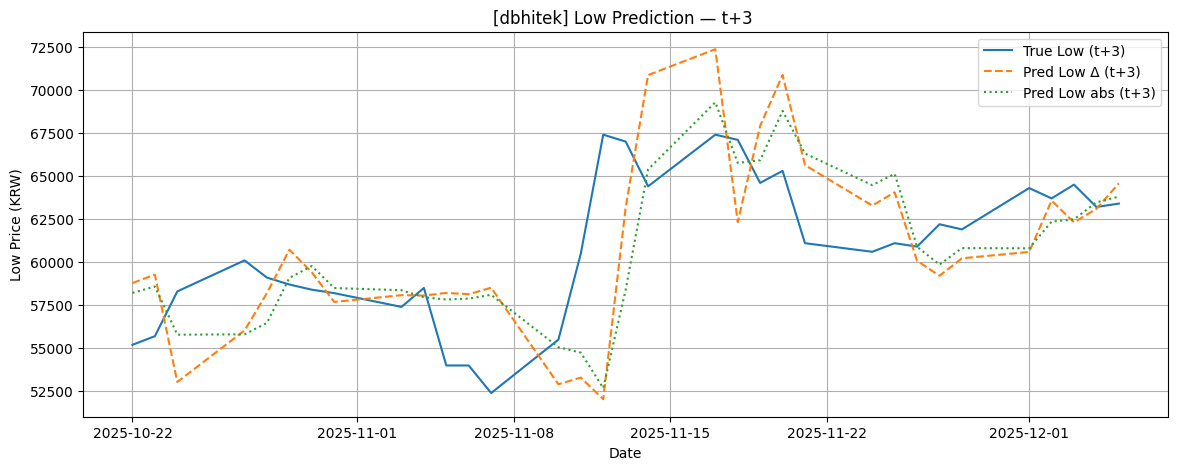

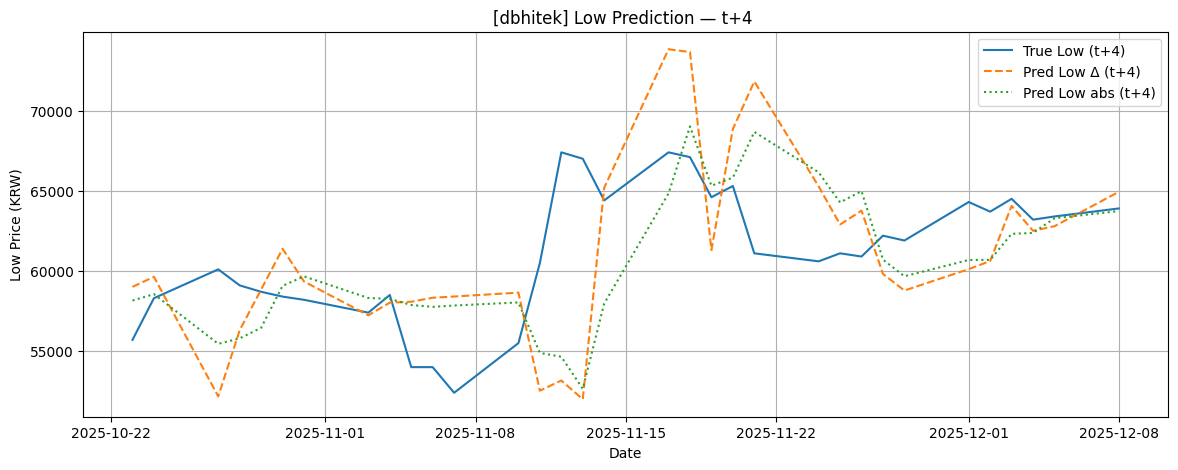

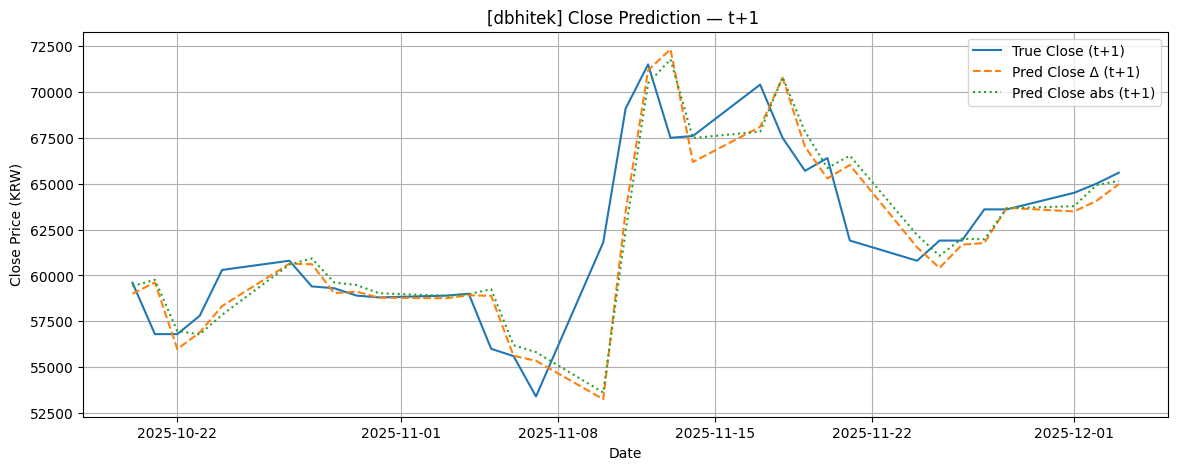

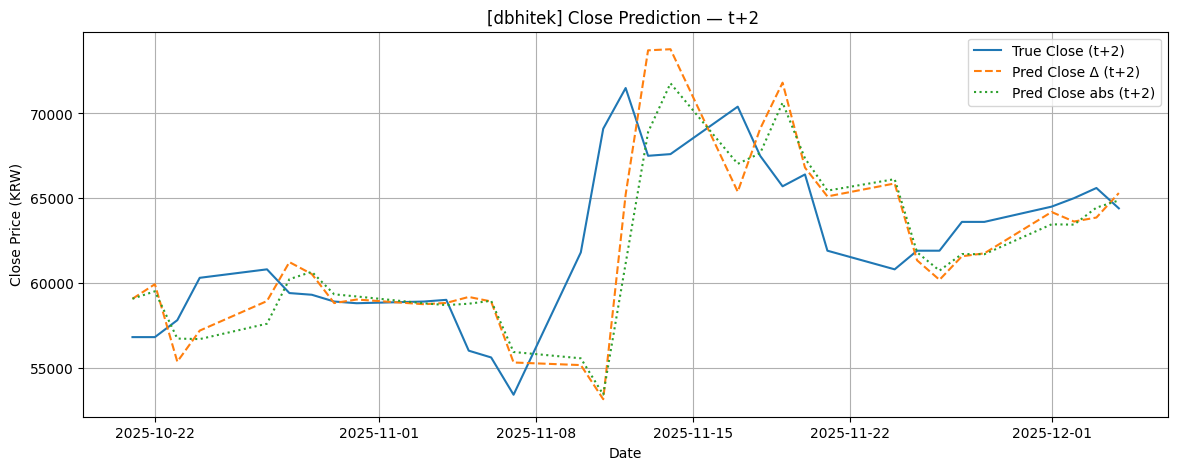

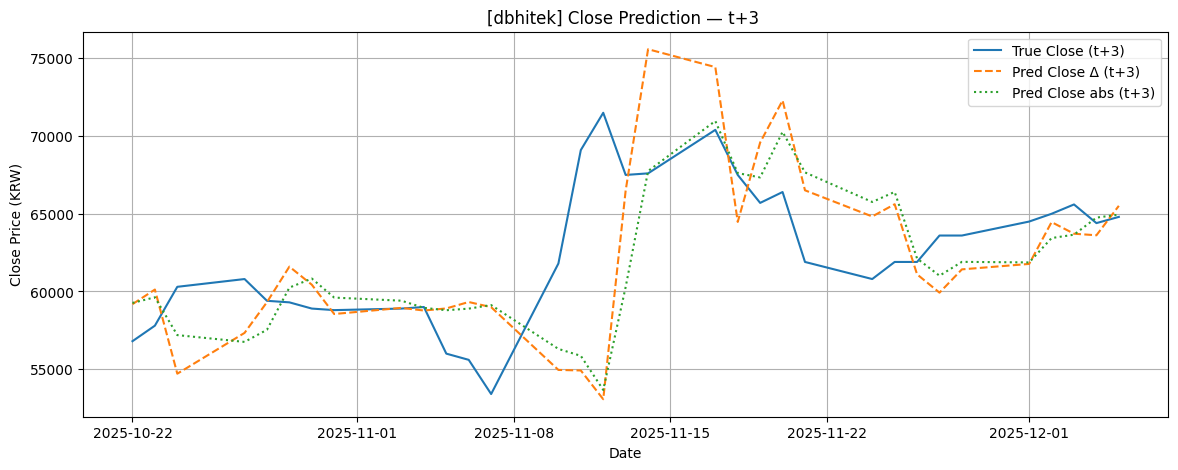

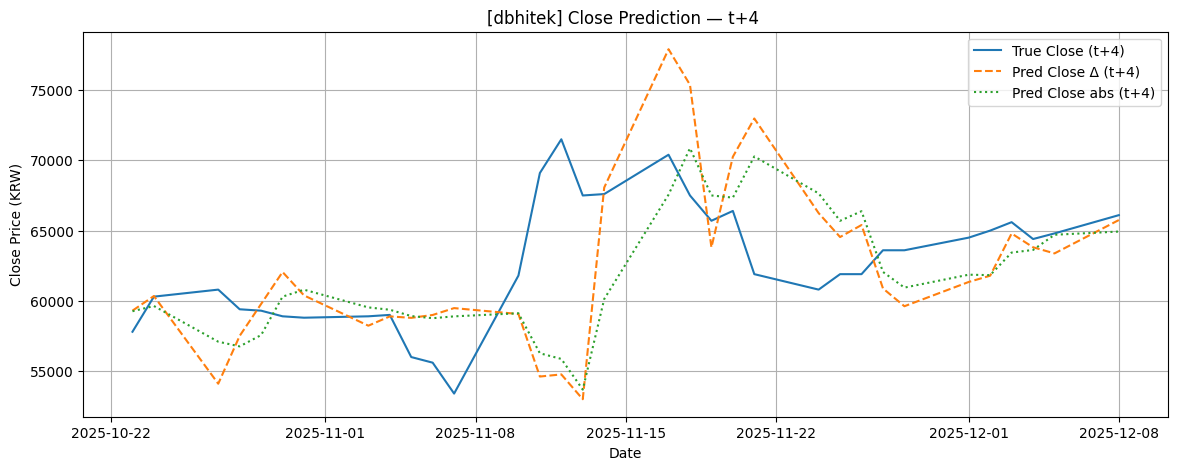

[skdnd] 테스트 예측 & 시각화
  t+1 Close RMSE (Δ기반, 원):      32.02
  Baseline RMSE (오늘 복사):        31.29


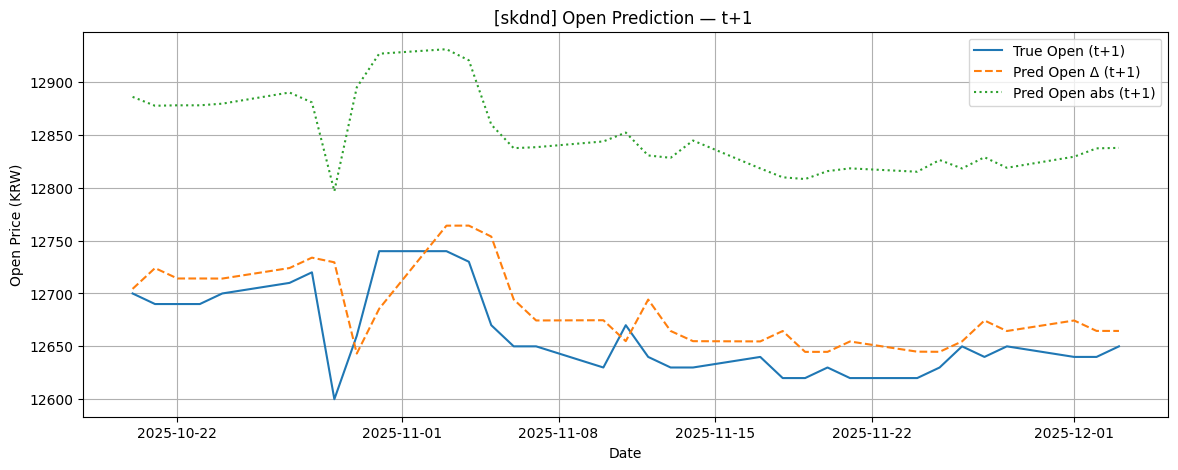

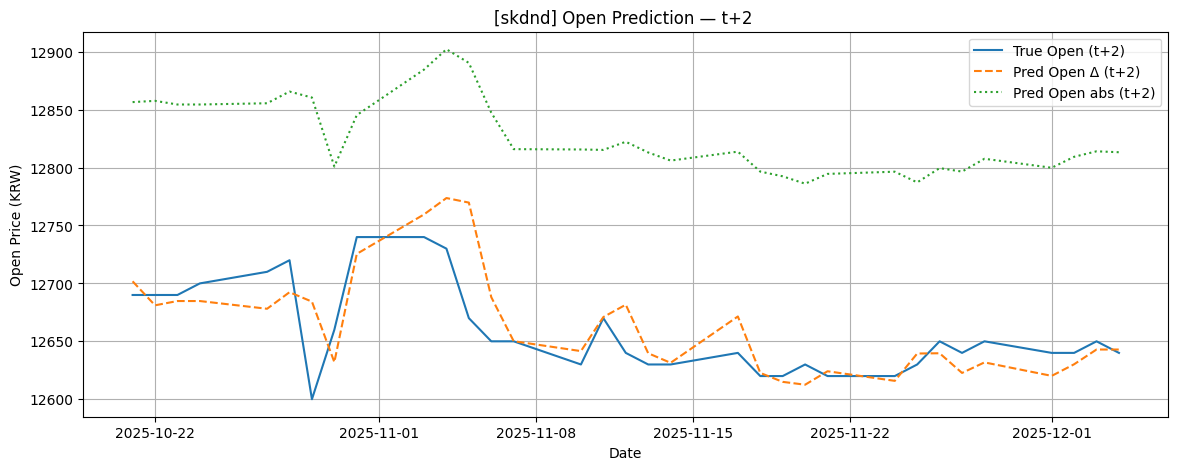

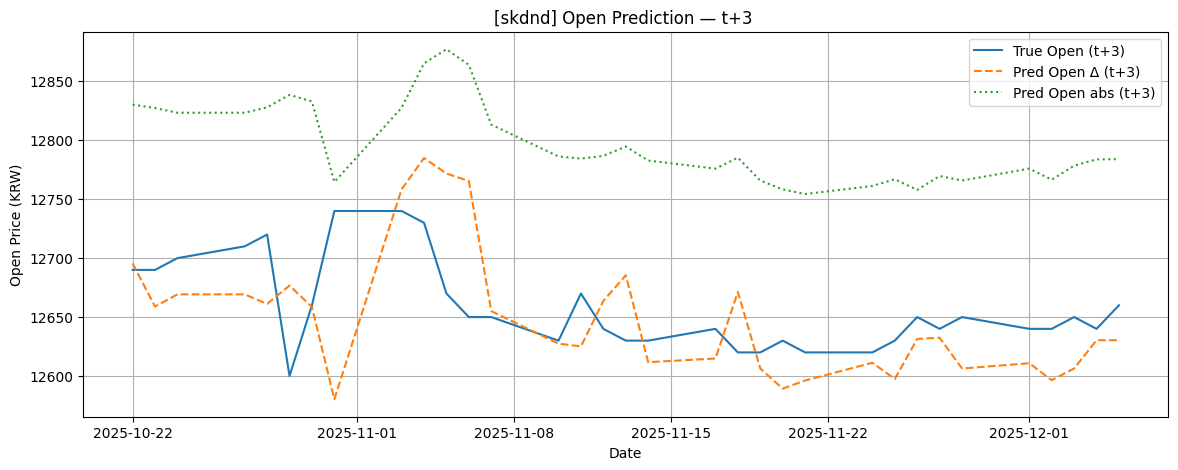

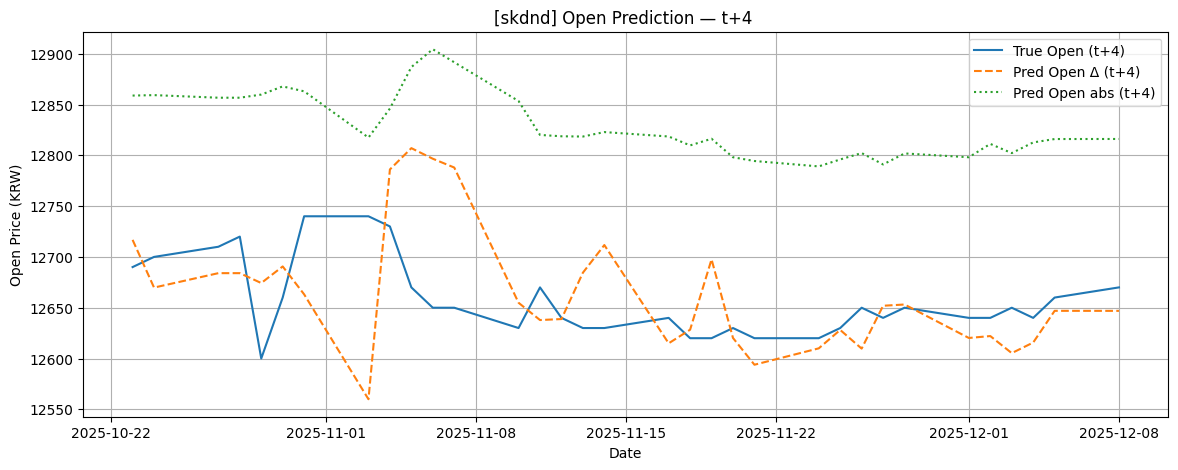

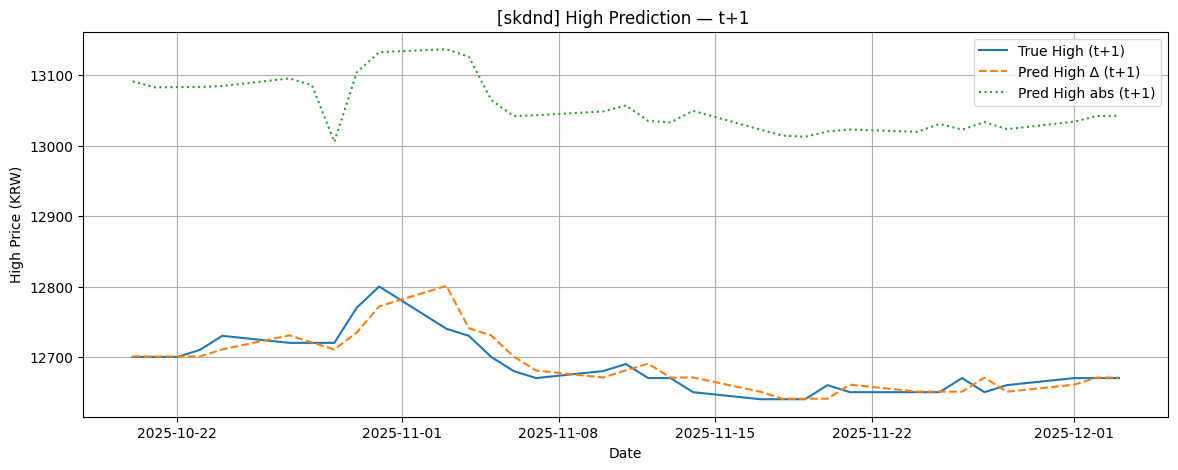

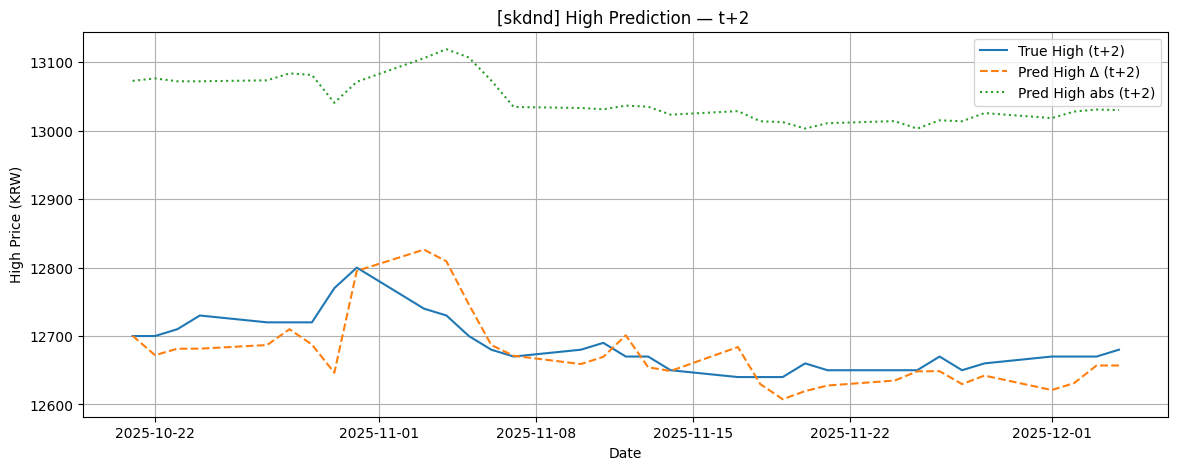

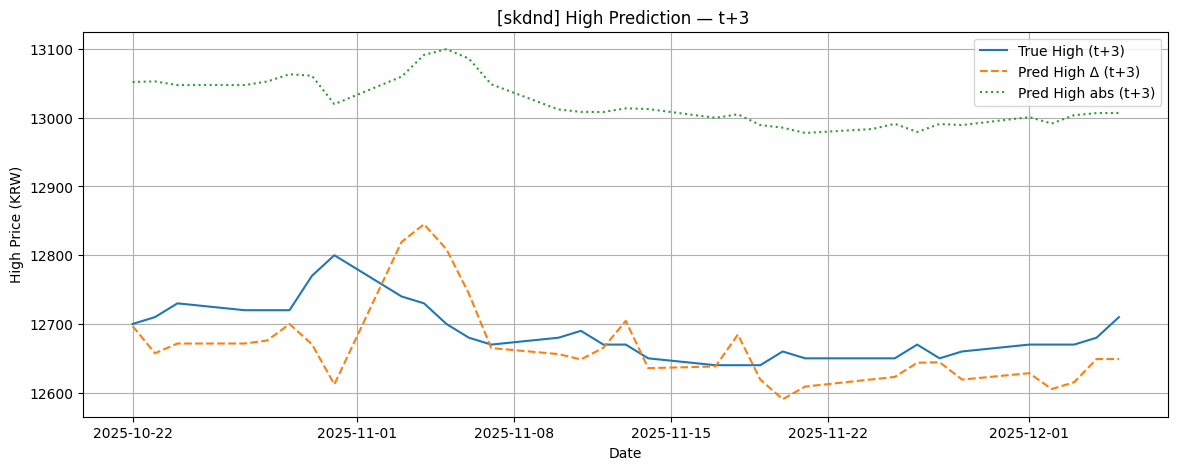

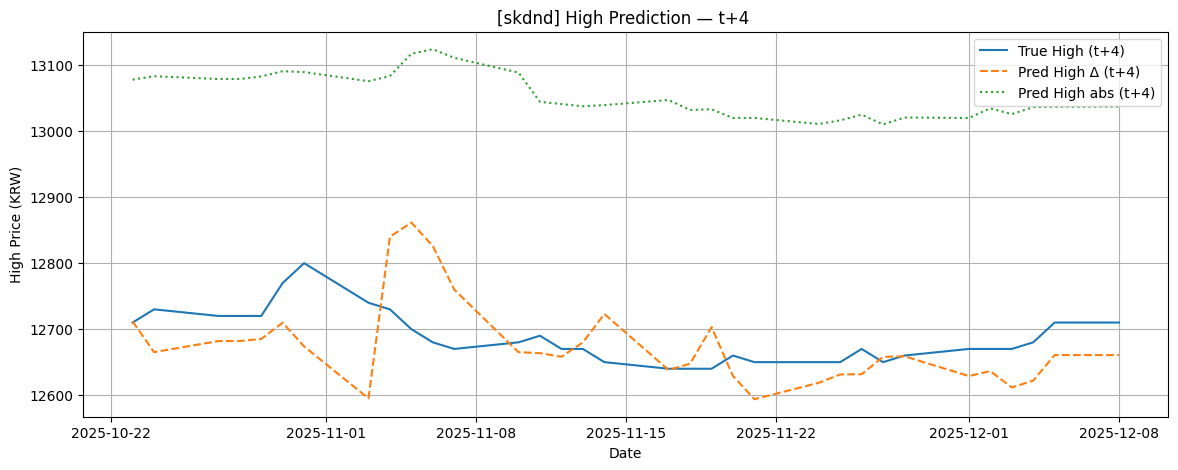

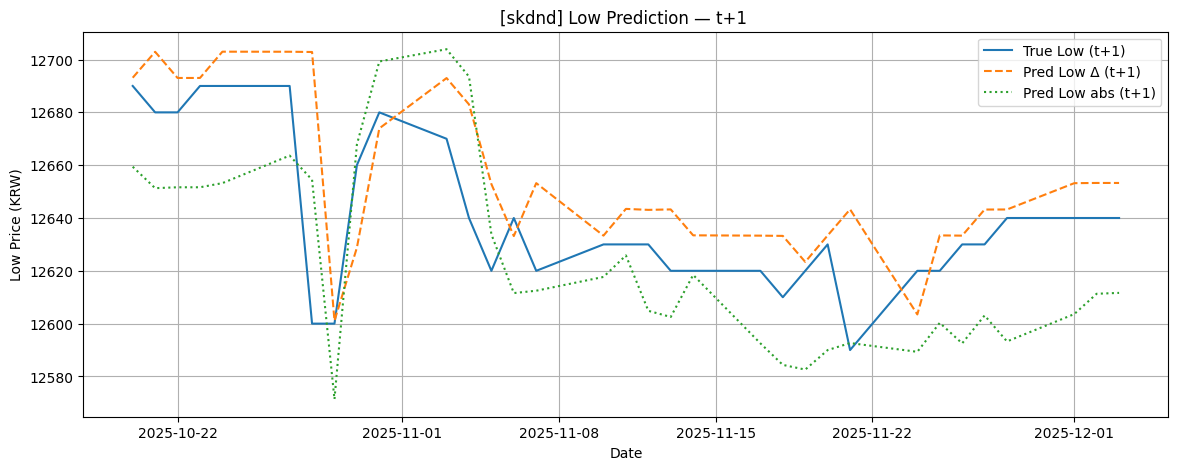

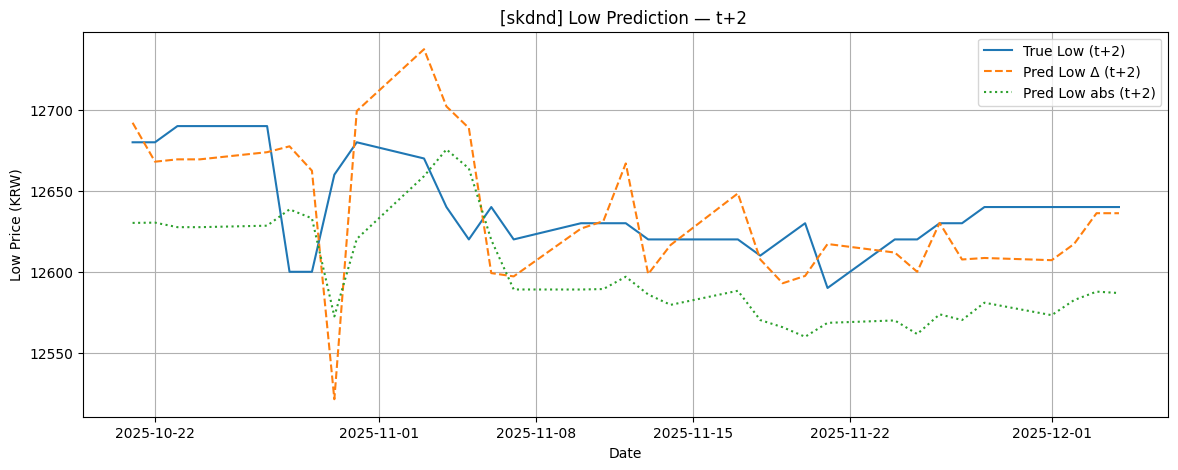

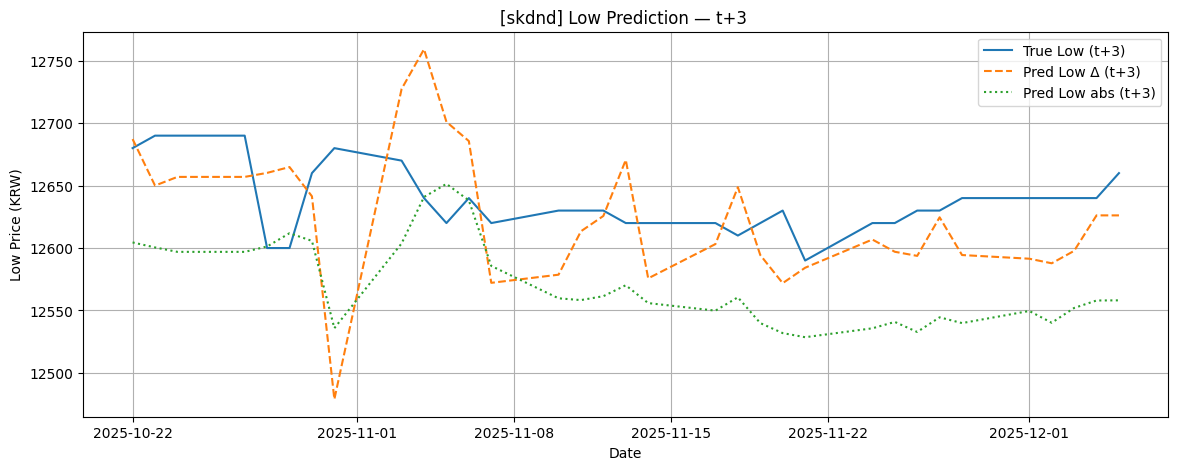

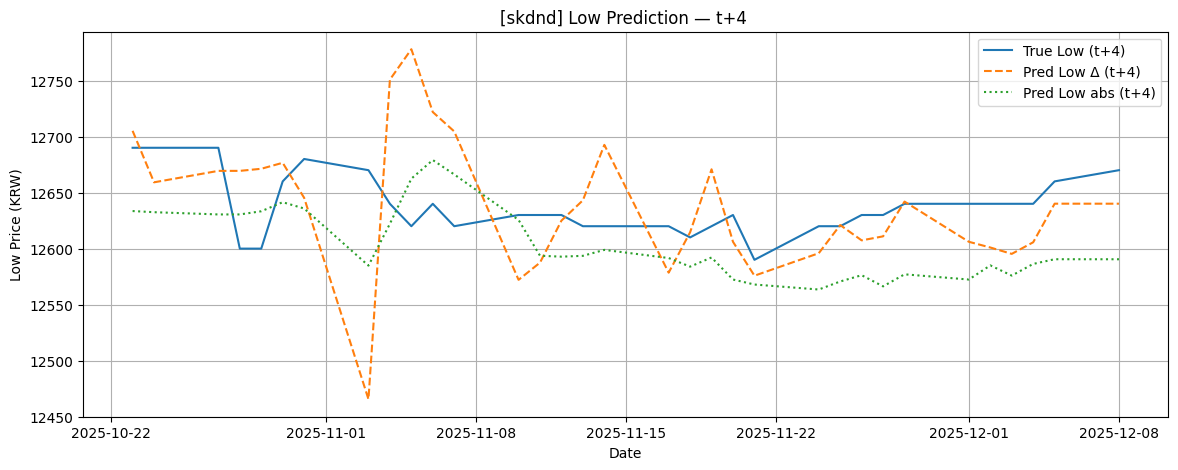

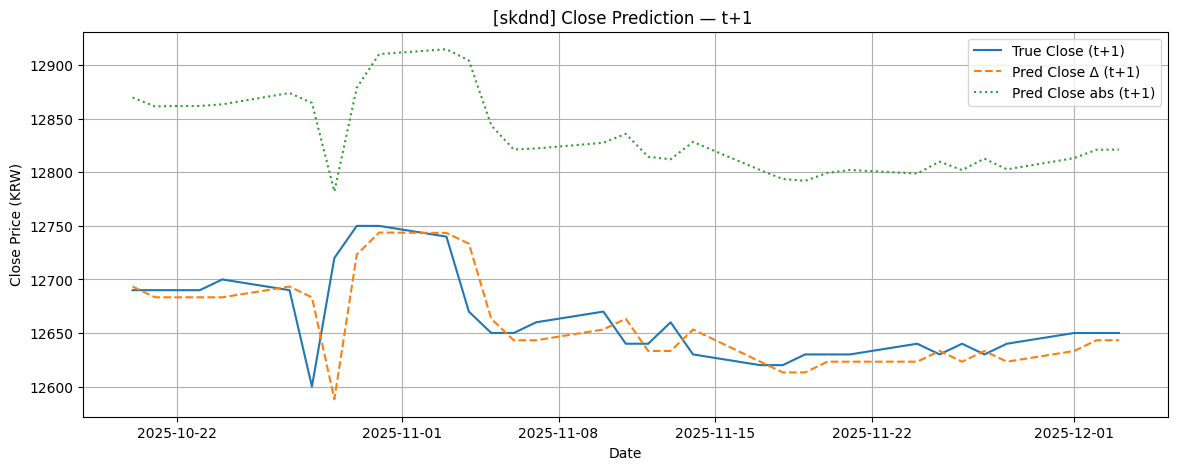

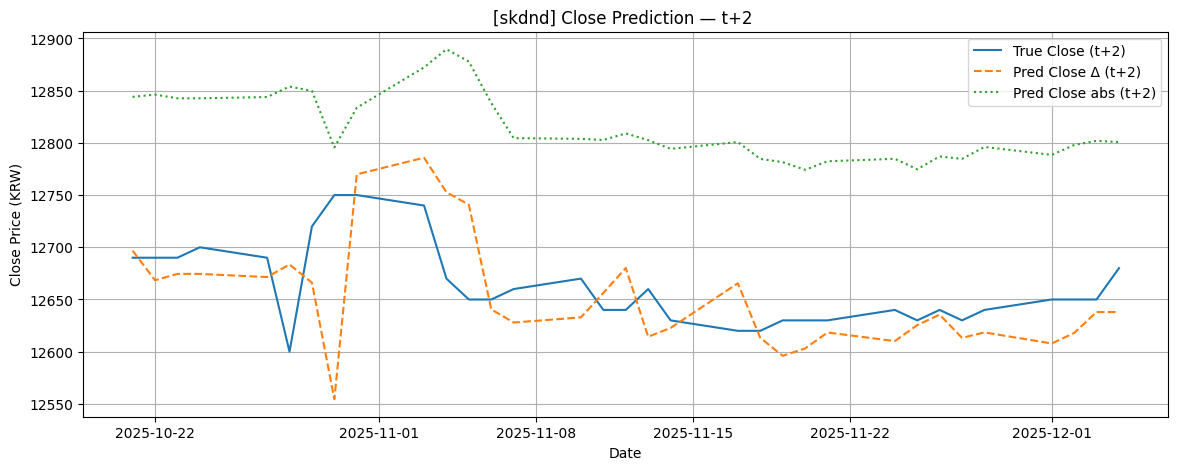

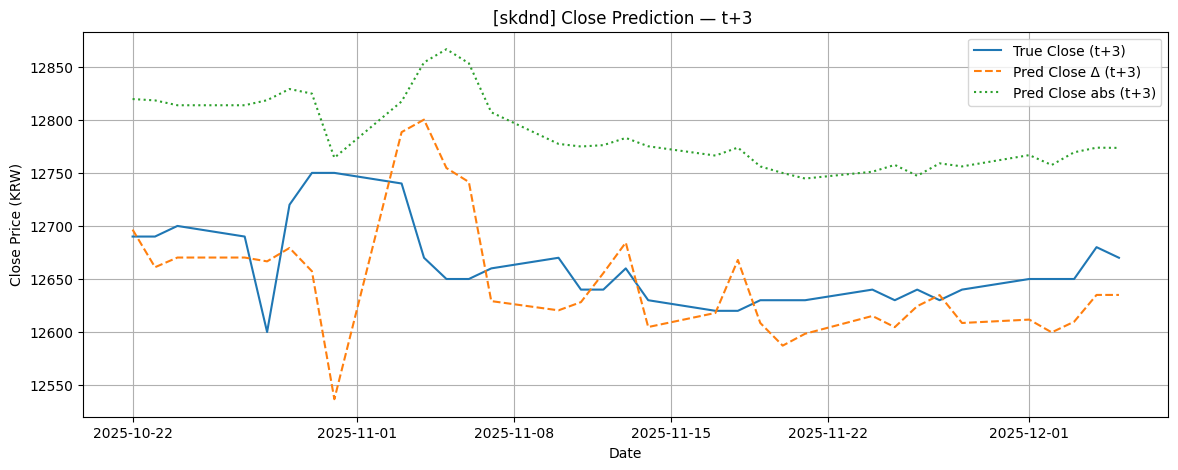

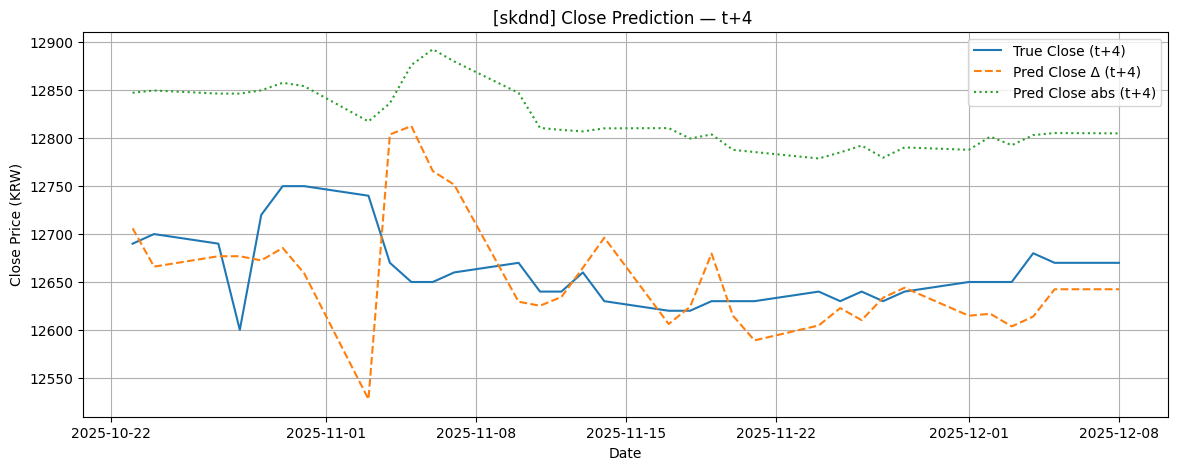

In [12]:
OHLC_NAMES = ["Open", "High", "Low", "Close"]

# 5개 종목 정보를 딕셔너리로 정리
stocks = {
    "shinpoong": {
        "train_df": shinpoong_train,
        "test_df":  shinpoong_test,
        "enc_test": shinpoong_enc_test_x,
        "dec_test": shinpoong_dec_test_x,
        "y_test_resid": shinpoong_test_y_resid,
        "last_test_ohlc": shinpoong_last_test_ohlc,
        "scaler": shinpoong_scaler,
        "ticker": "019170.KS"
    },
    "robostar": {
        "train_df": robostar_train,
        "test_df":  robostar_test,
        "enc_test": robostar_enc_test_x,
        "dec_test": robostar_dec_test_x,
        "y_test_resid": robostar_test_y_resid,
        "last_test_ohlc": robostar_last_test_ohlc,
        "scaler": robostar_scaler,
        "ticker": "090360.KQ"
    },
    "daihan": {
        "train_df": daihan_train,
        "test_df":  daihan_test,
        "enc_test": daihan_enc_test_x,
        "dec_test": daihan_dec_test_x,
        "y_test_resid": daihan_test_y_resid,
        "last_test_ohlc": daihan_last_test_ohlc,
        "scaler": daihan_scaler,
        "ticker": "023910.KQ"
    },
    "dbhitek": {
        "train_df": dbhitek_train,
        "test_df":  dbhitek_test,
        "enc_test": dbhitek_enc_test_x,
        "dec_test": dbhitek_dec_test_x,
        "y_test_resid": dbhitek_test_y_resid,
        "last_test_ohlc": dbhitek_last_test_ohlc,
        "scaler": dbhitek_scaler,
        "ticker": "000990.KS"
    },
    "skdnd": {
        "train_df": skdnd_train,
        "test_df":  skdnd_test,
        "enc_test": skdnd_enc_test_x,
        "dec_test": skdnd_dec_test_x,
        "y_test_resid": skdnd_test_y_resid,
        "last_test_ohlc": skdnd_last_test_ohlc,
        "scaler": skdnd_scaler,
        "ticker": "210980.KS"
    },
}


for name, info in stocks.items():
    print("="*60)
    print(f"[{name}] 테스트 예측 & 시각화")

    train_df       = info["train_df"]
    test_df        = info["test_df"]
    enc_test       = info["enc_test"]
    dec_test       = info["dec_test"]
    y_test_resid   = info["y_test_resid"]
    last_test_ohlc = info["last_test_ohlc"]
    scaler         = info["scaler"]

    # -----------------------------
    # 🔥 종목 ID 생성 (테스트용)
    # -----------------------------
    ticker_ids_test = np.full(len(enc_test), ticker_map[name])

    # -----------------------------
    # 🔥 모델 예측 (종목 ID 포함)
    # -----------------------------
    pred_resid_norm, pred_abs_norm = model.predict(
        [enc_test, dec_test, ticker_ids_test],
        verbose=0
    )

    true_resid_norm = y_test_resid

    # Δ 기반 가격 복원
    true_price, pred_price_resid = reconstruct_price_from_resid(
        pred_resid_norm,
        true_resid_norm,
        last_test_ohlc,
        scaler
    )

    # 절대값 출력 복원
    means = scaler.mean_[:4]
    stds  = scaler.scale_[:4]
    pred_price_abs = pred_abs_norm * stds + means

    # 이하 기존 그래프 출력 / RMSE 계산 동일
     # (N_test, H, 4)

    N, H, F = true_price.shape

    # === t+1 Close RMSE (잔차 기반) + baseline ===
    err_close_t1  = true_price[:, 0, 3] - pred_price_resid[:, 0, 3]
    rmse_close_t1 = np.sqrt(np.mean(err_close_t1**2))

    last_close    = last_test_ohlc[:, 3] * stds[3] + means[3]
    baseline_err  = true_price[:, 0, 3] - last_close
    baseline_rmse = np.sqrt(np.mean(baseline_err**2))

    print(f"  t+1 Close RMSE (Δ기반, 원):      {rmse_close_t1:.2f}")
    print(f"  Baseline RMSE (오늘 복사):        {baseline_rmse:.2f}")

    # 4) 날짜 index (train 마지막 window일 + test 전체)
    full_index = list(train_df.index[-window:]) + list(test_df.index)
    full_index = pd.to_datetime(full_index)

    # 5) OHLC 전부에 대해 t+1~t+4 시계열 시각화
    for feat_idx, feat_name in enumerate(OHLC_NAMES):   # 0:Open,1:High,2:Low,3:Close
        for step in range(H):   # t+1 ~ t+4
            true_series       = np.full(len(full_index), np.nan)
            pred_resid_series = np.full(len(full_index), np.nan)
            pred_abs_series   = np.full(len(full_index), np.nan)

            for i in range(N):
                idx = i + window + step
                if idx < len(full_index):
                    true_series[idx]       = true_price[i,        step, feat_idx]
                    pred_resid_series[idx] = pred_price_resid[i,  step, feat_idx]
                    pred_abs_series[idx]   = pred_price_abs[i,    step, feat_idx]

            plt.figure(figsize=(14, 5))
            plt.plot(full_index, true_series,
                     label=f"True {feat_name} (t+{step+1})")
            plt.plot(full_index, pred_resid_series, '--',
                     label=f"Pred {feat_name} Δ (t+{step+1})")
            plt.plot(full_index, pred_abs_series, ':',
                     label=f"Pred {feat_name} abs (t+{step+1})")
            plt.title(
                f"[{name}] {feat_name} Prediction — t+{step+1} "

            )
            plt.xlabel("Date")
            plt.ylabel(f"{feat_name} Price (KRW)")
            plt.grid(True)
            plt.legend()
            plt.show()


In [ ]:
# --------------------------------------
# 🔥 모든 종목 t+1~t+4 RMSE (잔차 + 절대값 예측 비교)
# --------------------------------------

rmse_results = {}  # 종목별 RMSE 저장

for name, info in stocks.items():
    print("="*60)
    print(f"[{name}] RMSE 계산")

    train_df       = info["train_df"]
    test_df        = info["test_df"]
    enc_test       = info["enc_test"]
    dec_test       = info["dec_test"]
    y_test_resid   = info["y_test_resid"]
    last_test_ohlc = info["last_test_ohlc"]
    scaler         = info["scaler"]

    # 🔥 종목 ID 생성
    ticker_ids_test = np.full(len(enc_test), ticker_map[name])

    # 🔥 모델 예측
    pred_resid_norm, pred_abs_norm = model.predict(
        [enc_test, dec_test, ticker_ids_test],
        verbose=0
    )

    # --------------------------
    # Δ 기반 복원 (잔차 기반 절대값)
    # --------------------------
    true_price, pred_price_resid = reconstruct_price_from_resid(
        pred_resid_norm,
        y_test_resid,
        last_test_ohlc,
        scaler
    )

    # --------------------------
    # 절대값 기반 복원
    # --------------------------
    means = scaler.mean_[:4]
    stds  = scaler.scale_[:4]
    pred_price_abs = pred_abs_norm * stds + means

    N, H, F = true_price.shape

    rmse_open_resid  = []
    rmse_close_resid = []

    rmse_open_abs  = []
    rmse_close_abs = []


    # --------------------------
    # 🔥 t+1 ~ t+4 RMSE 계산
    # --------------------------
    for step in range(H):

        # ------------ 잔차 기반 ------------
        rmse_o_resid = np.sqrt(np.mean((true_price[:, step, 1] - pred_price_resid[:, step, 1])**2))
        rmse_c_resid = np.sqrt(np.mean((true_price[:, step, 2] - pred_price_resid[:, step, 2])**2))

        rmse_open_resid.append(rmse_o_resid)
        rmse_close_resid.append(rmse_c_resid)

        # ------------ 절대값 기반 ------------
        rmse_o_abs = np.sqrt(np.mean((true_price[:, step, 1] - pred_price_abs[:, step, 1])**2))
        rmse_c_abs = np.sqrt(np.mean((true_price[:, step, 2] - pred_price_abs[:, step, 2])**2))

        rmse_open_abs.append(rmse_o_abs)
        rmse_close_abs.append(rmse_c_abs)

    # 저장
    rmse_results[name] = {
        "resid": {
            "Open": rmse_open_resid,
            "Close": rmse_close_resid,
        },
        "abs": {
            "Open": rmse_open_abs,
            "Close": rmse_close_abs,
        }
    }

# --------------------------
# 🔥 RMSE 출력 (정리된 형태)
# --------------------------
print("\n\n========== RMSE SUMMARY ==========")

for name, vals in rmse_results.items():
    print(f"\n📌 {name}")

    for step in range(4):
        print(
            f"  t+{step+1} | "
            f"Resid(High): {vals['resid']['Open'][step]:.2f}  |  "
            f"Resid(Low): {vals['resid']['Close'][step]:.2f}  ||  "
            f"ABS(High): {vals['abs']['Open'][step]:.2f}  |  "
            f"ABS(Low): {vals['abs']['Close'][step]:.2f}"
        )


[shinpoong] RMSE 계산


ValueError: Input 0 of layer "transformer_seq2seq_with_ticker" is incompatible with the layer: expected shape=(None, 40, 18), found shape=(2, 40, 4)

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------------
# RMSE 함수
# -----------------------------------
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

# -----------------------------------
# 정확도 함수
# -----------------------------------
def accuracy(true, pred):
    # |true|가 0에 가까울 때 0으로 나눌 위험 방지
    eps = 1e-9
    return 1 - np.mean(np.abs(pred - true) / (np.abs(true) + eps))


# ===================================
# 🔥 결과 저장 리스트
# ===================================
rows_resid = []
rows_abs   = []
rows_best  = []

FEATURES = ["Open", "High", "Low", "Close"]

# ===================================
# 🔥 모든 종목 반복
# ===================================
for name, info in stocks.items():

    enc_test       = info["enc_test"]
    dec_test       = info["dec_test"]
    y_test_resid   = info["y_test_resid"]
    last_test_ohlc = info["last_test_ohlc"]
    scaler         = info["scaler"]

    ticker_ids_test = np.full(len(enc_test), ticker_map[name])

    # 모델 예측
    pred_resid_norm, pred_abs_norm = model.predict(
        [enc_test, dec_test, ticker_ids_test],
        verbose=0
    )

    # ----- Δ 기반 복원 -----
    true_price, pred_price_resid = reconstruct_price_from_resid(
        pred_resid_norm, y_test_resid, last_test_ohlc, scaler
    )

    # ----- 절대값 기반 복원 -----
    means = scaler.mean_[:4]
    stds  = scaler.scale_[:4]
    pred_price_abs = pred_abs_norm * stds + means

    # ===================================
    # 🔥 RMSE + Accuracy 계산
    # ===================================
    for step in range(4):  # t+1~t+4
        for f_idx, f_name in enumerate(FEATURES):

            true_v = true_price[:, step, f_idx]

            # --- 잔차 기반 ---
            pred_r = pred_price_resid[:, step, f_idx]
            rmse_r = rmse(true_v, pred_r)
            acc_r  = accuracy(true_v, pred_r)

            # --- 절대값 기반 ---
            pred_a = pred_price_abs[:, step, f_idx]
            rmse_a = rmse(true_v, pred_a)
            acc_a  = accuracy(true_v, pred_a)

            # RMSE 기록
            rows_resid.append([name, f"t+{step+1}", f_name, rmse_r])
            rows_abs.append([name, f"t+{step+1}", f_name, rmse_a])

            # 더 좋은 방식 선택
            best_method = "Resid" if rmse_r < rmse_a else "ABS"
            best_acc = acc_r if best_method == "Resid" else acc_a

            # Best 시트 기록
            rows_best.append([
                name, f"t+{step+1}", f_name,
                rmse_r, rmse_a,              # RMSE 비교
                acc_r, acc_a,                # Accuracy 비교
                best_method, best_acc        # 선택 결과
            ])

# ===================================
# 🔥 DataFrame 변환
# ===================================
df_resid = pd.DataFrame(rows_resid, columns=["Stock", "Horizon", "Feature", "RMSE"])
df_abs   = pd.DataFrame(rows_abs,   columns=["Stock", "Horizon", "Feature", "RMSE"])

df_best = pd.DataFrame(rows_best,
    columns=[
        "Stock", "Horizon", "Feature",
        "Resid_RMSE", "ABS_RMSE",
        "Resid_Accuracy", "ABS_Accuracy",
        "Best_Method", "Best_Accuracy"
    ]
)

# ===================================
# 🔥 엑셀 저장
# ===================================
output_path = "/content/rmse_results.xlsx"

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    df_resid.to_excel(writer, index=False, sheet_name="Resid_RMSE")
    df_abs.to_excel(writer, index=False, sheet_name="ABS_RMSE")
    df_best.to_excel(writer, index=False, sheet_name="Best_Method")

print("엑셀 저장 완료:", output_path)


ValueError: Input 0 of layer "transformer_seq2seq_with_ticker" is incompatible with the layer: expected shape=(None, 40, 18), found shape=(2, 40, 4)

In [18]:
import os
import pandas as pd

# ==============================================================
# 🔥 모든 종목: 마지막 윈도우(t+1~t+4) 예측을 하나의 엑셀로 통합 저장
# ==============================================================

all_rows = []

for name, info in stocks.items():
    print(f"[{name}] 마지막 윈도우 예측 수집 중...")

    train_df       = info["train_df"]
    test_df        = info["test_df"]
    enc_test       = info["enc_test"]
    dec_test       = info["dec_test"]
    y_test_resid   = info["y_test_resid"]
    last_test_ohlc = info["last_test_ohlc"]
    scaler         = info["scaler"]

    # 🔥 종목 ID
    ticker_ids_test = np.full(len(enc_test), ticker_map[name])

    # 🔥 전체 test 구간 예측
    pred_resid_norm, pred_abs_norm = model.predict(
        [enc_test, dec_test, ticker_ids_test],
        verbose=0
    )

    # Δ 기반 복원 (true + resid 예측)
    true_price, pred_price_resid = reconstruct_price_from_resid(
        pred_resid_norm,
        y_test_resid,
        last_test_ohlc,
        scaler
    )

    # 절대값 헤드 기반 복원
    means = scaler.mean_[:4]
    stds  = scaler.scale_[:4]
    pred_price_abs = pred_abs_norm * stds + means

    # --------------------------
    # 🔥 마지막 윈도우 index & 날짜
    # --------------------------
    last_idx = -1                                      # 마지막 윈도우
    H = true_price.shape[1]                            # horizon (보통 4)
    dates = test_df.index[-H:]                         # test_df의 마지막 H일 = t+1~t+H

    # 안전하게 길이 맞춰주기
    assert len(dates) == H

    # --------------------------
    # 🔥 행 단위로 모아서 나중에 concat
    # --------------------------
    for step in range(H):
        row = {
            "Ticker": name,
            "Horizon": f"t+{step+1}",
            "Date": dates[step],

            # True OHLC
            "True_Open":  float(true_price[last_idx, step, 0]),
            "True_High":  float(true_price[last_idx, step, 1]),
            "True_Low":   float(true_price[last_idx, step, 2]),
            "True_Close": float(true_price[last_idx, step, 3]),

            # Resid 기반 예측
            "Pred_Open_Resid":  float(pred_price_resid[last_idx, step, 0]),
            "Pred_High_Resid":  float(pred_price_resid[last_idx, step, 1]),
            "Pred_Low_Resid":   float(pred_price_resid[last_idx, step, 2]),
            "Pred_Close_Resid": float(pred_price_resid[last_idx, step, 3]),

            # Abs 헤드 기반 예측
            "Pred_Open_Abs":  float(pred_price_abs[last_idx, step, 0]),
            "Pred_High_Abs":  float(pred_price_abs[last_idx, step, 1]),
            "Pred_Low_Abs":   float(pred_price_abs[last_idx, step, 2]),
            "Pred_Close_Abs": float(pred_price_abs[last_idx, step, 3]),
        }
        all_rows.append(row)

# --------------------------------------------------
# 🔥 하나의 DataFrame으로 통합 후 엑셀 저장
# --------------------------------------------------
df_all = pd.DataFrame(all_rows)

output_path = "last_window_all_stocks.xlsx"
df_all.to_excel(output_path, index=False)

print(f"✅ 통합 파일 저장 완료: {output_path}")


[shinpoong] 마지막 윈도우 예측 수집 중...
[robostar] 마지막 윈도우 예측 수집 중...
[daihan] 마지막 윈도우 예측 수집 중...
[dbhitek] 마지막 윈도우 예측 수집 중...
[skdnd] 마지막 윈도우 예측 수집 중...
✅ 통합 파일 저장 완료: last_window_all_stocks.xlsx


In [ ]:
from google.colab import shee

MessageError: Error: credential propagation was unsuccessful